# Commodity Food Pricing: Data Analysis
**By:** `MSOE AI-Club "Nourish" Student Research Team`<br/>
**Primary Notebook Developers:** Ben Paulson, _____________

**Notebook Purpose:** to analyze the relationships between the changing prices of international food commodities over time compared to other, potentially significant, economic inidicators. By downloading associated datasets, cleaning them to provide more significant signal, and then analyzing them, we can gain insight into determining how economic indiciators -- along with previous food-price trend data -- can be used to predict future food prices. The outcome of this analysis will be encoded data-input to a model which can accurately perform this prediction, hosted in a separate notebook. [FAO Official Statement on the Importance of Research Like This](https://youtu.be/sZx3hhnEHiI). There is also significant documentation with each section for both code/purpose sanity, sake of future reproducibility, and to help other members of the `MSOE AI-Club "Nourish" Student Research Team` understand the code and its purpose.
* **Part 1: Retrieving Data**
* **Part 2: EDA & Statistical Analysis**

**Research Context:** This research is being conducted as part of the MSOE AI-Club's "Nourish" project, which aims to use machine learning to predict future food prices in order to help farmers in developing countries make better decisions about food storage and crop selection, achieved through the accurate warning administration and prediction of food commodity pricing data by country and food market. This project is pending as part of a relationship with the United Nation's Food and Agriculture Organization (FAO).

In [67]:
!pip install PyPDF2

     ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
     - -------------------------------------- 10.2/232.6 kB ? eta -:--:--
     ---- -------------------------------- 30.7/232.6 kB 435.7 kB/s eta 0:00:01
     ------------------- ---------------- 122.9/232.6 kB 901.1 kB/s eta 0:00:01
     -------------------------------------- 232.6/232.6 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Webscraper applications (Selenium 4)
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PyPDF2

# Machine Learning
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.stats import spearmanr
import tensorflow as tf

# Internal Python Imports
import time
import os
import re

## Part 1: Retrieving Data
<span style="color: red;">**If you have already installed the data locally, you may skip to Section 1.7**</span>

The data used throughout this research is as follows:
* **PROTEUS Index:** An encoded food-security indicator developed by the UN FAO. Ranges from 0 to 1; the closer the value to zero, the greater the food security. Also, this value "proves flexible enough to capture sudden onset crises and to reflect the main drivers that can dramatically affect a country's food security in the short run" (FAO).
    * [PROTEUS Index Data](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n)
    * [Data & Data-Explanation Found Here](https://dataviz.vam.wfp.org/version2/reports/global-coverage-proteus-food-security-index-oct-2019)
    * [Original Research Paper](https://www.sciencedirect.com/science/article/abs/pii/S0305750X19303572)
* **Food Indices:** The FAO has developed a number of indices which measure the overall price globally for varying commodity categories, including a general "food" index. These indices are as follows: Food, meat, cereal, sugar, oils, and dairy. These indices are important because they provide a general overview of the global food market, which can be used to determine the overall trend of the market.
    * [Food Indices Data](http://www.fao.org/worldfoodsituation/foodpricesindex/en/)
* **Current Food Commodity Prices:** The current value of different food commodities divided by country which is selling those food commodities. Choosing between food commodity pricing at the international, wholesale, or retail price point boils down to both the purpose and accuracy of this research. Respectively, this research aims to provide a model which can accurately predict the future price of food commodities for country food security, and more data (including futures data) is available at the international level. Therefore, the international price of food commodities is used as opposed to the other options.
    * **International Prices:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international
    * **Domestic Prices (Wholesale & Retail):** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/domestic
* **Futures Trend Data:** Futures are call options where traders estimate how the price will fluctuate in the future. The benefit to traders is that if they purchase a futures contract where the monetary value is less than the actual value at that time, the trader will purchase that commodity at a discount; however, the trader can cancel their contract if that actual value is lower than the contracted futures value. The benefit to the sellers is they will at least get the guaranteed premium income if the value of the commodity depreciates. Futures are important because they are currently the best indicator for how the traders believe the future of the market will perform in the short/medium term. Please note, these futures have contracts that expire within 3 months of the futures set prices available in this dataset.
    * [Yahoo Finance Futures Data](https://finance.yahoo.com/commodities/)
        * [International (ICE) Sugar Futures](https://finance.yahoo.com/chart/SB%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJzdHVkaWVzIjp7IuKAjHZvbCB1bmRy4oCMIjp7InR5cGUiOiJ2b2wgdW5kciIsImlucHV0cyI6eyJTZXJpZXMiOiJzZXJpZXMiLCJpZCI6IuKAjHZvbCB1bmRy4oCMIiwiZGlzcGxheSI6IuKAjHZvbCB1bmRy4oCMIn0sIm91dHB1dHMiOnsiVXAgVm9sdW1lIjoiIzBkYmQ2ZWVlIiwiRG93biBWb2x1bWUiOiIjZmY1NTQ3ZWUifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQiLCJlZGl0TW9kZSI6dHJ1ZX0sImRpc2FibGVkIjpmYWxzZX19LCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlNCPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJTQj1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IlNCPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6IndlZWsiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XX0sImV2ZW50cyI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWUsInRyYWRpbmdIb3Jpem9uIjoibm9uZSIsInNpZ0RldkV2ZW50cyI6W119LCJwcmVmZXJlbmNlcyI6e319)
        * [International (CBOT) Corn Futures](https://finance.yahoo.com/chart/ZC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDkyMTk4NTgxNTYwMjgzLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWkM9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpDPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWkM9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Oat Futures](https://finance.yahoo.com/chart/ZO%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlpPPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJaTz1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IlpPPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6IndlZWsiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Wheat Futures](https://finance.yahoo.com/chart/KE%3DF)
        * [International (CBOT) Rough Rice Futures](https://finance.yahoo.com/chart/ZR%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTY4OTc1OTY3ODMxMDgyLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWlI9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpSPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlI9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Soybean Oil Futures](https://finance.yahoo.com/chart/ZR%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTY4OTc1OTY3ODMxMDgyLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiWlI9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpSPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlI9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (CBOT) Soybean Futures](https://finance.yahoo.com/chart/ZS%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlpTPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOm51bGwsIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IlpTPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiWlM9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayIsInRpbWVVbml0IjpudWxsLCJzZXRTcGFuIjpudWxsfV0sInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7IlNlcmllcyI6InNlcmllcyIsImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMGRiZDZlZWUiLCJEb3duIFZvbHVtZSI6IiNmZjU1NDdlZSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCIsImVkaXRNb2RlIjp0cnVlLCJwYW5lbE5hbWUiOiJjaGFydCJ9LCJkaXNhYmxlZCI6ZmFsc2V9fSwicmFuZ2UiOm51bGx9LCJldmVudHMiOnsiZGl2cyI6dHJ1ZSwic3BsaXRzIjp0cnVlLCJ0cmFkaW5nSG9yaXpvbiI6Im5vbmUiLCJzaWdEZXZFdmVudHMiOltdfSwicHJlZmVyZW5jZXMiOnsiY3VycmVudFByaWNlTGluZSI6dHJ1ZSwiZGlzcGxheUNyb3NzaGFpcnNXaXRoRHJhd2luZ1Rvb2wiOmZhbHNlLCJkcmFnZ2luZyI6eyJzZXJpZXMiOnRydWUsInN0dWR5Ijp0cnVlLCJ5YXhpcyI6dHJ1ZX0sImRyYXdpbmdzIjpudWxsLCJoaWdobGlnaHRzUmFkaXVzIjoxMCwiaGlnaGxpZ2h0c1RhcFJhZGl1cyI6MzAsIm1hZ25ldCI6ZmFsc2UsImhvcml6b250YWxDcm9zc2hhaXJGaWVsZCI6bnVsbCwibGFiZWxzIjp0cnVlLCJsYW5ndWFnZSI6bnVsbCwidGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwid2hpdGVzcGFjZSI6NTAsInpvb21JblNwZWVkIjpudWxsLCJ6b29tT3V0U3BlZWQiOm51bGwsInpvb21BdEN1cnJlbnRNb3VzZVBvc2l0aW9uIjpmYWxzZX19)
        * [International (CME) Live Cattle Futures](https://finance.yahoo.com/chart/LE%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJ3ZWVrIiwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjpudWxsLCJjYW5kbGVXaWR0aCI6MS4wMTMxNjk0NDY4ODMyMzA5LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiTEU9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IkxFPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiTEU9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayIsInRpbWVVbml0IjpudWxsLCJzZXRTcGFuIjp7ImJhc2UiOiJhbGwiLCJtdWx0aXBsaWVyIjoxfX1dLCJzdHVkaWVzIjp7IuKAjHZvbCB1bmRy4oCMIjp7InR5cGUiOiJ2b2wgdW5kciIsImlucHV0cyI6eyJTZXJpZXMiOiJzZXJpZXMiLCJpZCI6IuKAjHZvbCB1bmRy4oCMIiwiZGlzcGxheSI6IuKAjHZvbCB1bmRy4oCMIn0sIm91dHB1dHMiOnsiVXAgVm9sdW1lIjoiIzBkYmQ2ZWVlIiwiRG93biBWb2x1bWUiOiIjZmY1NTQ3ZWUifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQiLCJlZGl0TW9kZSI6dHJ1ZSwicGFuZWxOYW1lIjoiY2hhcnQifSwiZGlzYWJsZWQiOmZhbHNlfX19LCJldmVudHMiOnsiZGl2cyI6dHJ1ZSwic3BsaXRzIjp0cnVlLCJ0cmFkaW5nSG9yaXpvbiI6Im5vbmUiLCJzaWdEZXZFdmVudHMiOltdfSwicHJlZmVyZW5jZXMiOnsiY3VycmVudFByaWNlTGluZSI6dHJ1ZSwiZGlzcGxheUNyb3NzaGFpcnNXaXRoRHJhd2luZ1Rvb2wiOmZhbHNlLCJkcmFnZ2luZyI6eyJzZXJpZXMiOnRydWUsInN0dWR5Ijp0cnVlLCJ5YXhpcyI6dHJ1ZX0sImRyYXdpbmdzIjpudWxsLCJoaWdobGlnaHRzUmFkaXVzIjoxMCwiaGlnaGxpZ2h0c1RhcFJhZGl1cyI6MzAsIm1hZ25ldCI6ZmFsc2UsImhvcml6b250YWxDcm9zc2hhaXJGaWVsZCI6bnVsbCwibGFiZWxzIjp0cnVlLCJsYW5ndWFnZSI6bnVsbCwidGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwid2hpdGVzcGFjZSI6NTAsInpvb21JblNwZWVkIjpudWxsLCJ6b29tT3V0U3BlZWQiOm51bGwsInpvb21BdEN1cnJlbnRNb3VzZVBvc2l0aW9uIjpmYWxzZX19)
        * [International (ICE) Cocoa Futures](https://finance.yahoo.com/chart/CC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjMuOTk2MzMwMTAyMjg0NzQ5NSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibW91bnRhaW4iLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IkNDPUYiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9LCJvdXRsaWVycyI6ZmFsc2UsImFuaW1hdGlvbiI6dHJ1ZSwiaGVhZHNVcCI6eyJzdGF0aWMiOnRydWUsImR5bmFtaWMiOmZhbHNlLCJmbG9hdGluZyI6ZmFsc2V9LCJsaW5lV2lkdGgiOjIsImZ1bGxTY3JlZW4iOnRydWUsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzeW1ib2xzIjpbeyJzeW1ib2wiOiJDQz1GIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IkNDPUYiLCJxdW90ZVR5cGUiOiJGVVRVUkUiLCJleGNoYW5nZVRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIm1hcmtldCI6InVzMjRfbWFya2V0In0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6Im1vbnRoIiwidGltZVVuaXQiOm51bGwsInNldFNwYW4iOnsiYmFzZSI6ImFsbCIsIm11bHRpcGxpZXIiOjF9fV0sInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7IlNlcmllcyI6InNlcmllcyIsImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMGRiZDZlZWUiLCJEb3duIFZvbHVtZSI6IiNmZjU1NDdlZSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCIsImVkaXRNb2RlIjp0cnVlLCJwYW5lbE5hbWUiOiJjaGFydCJ9LCJkaXNhYmxlZCI6ZmFsc2V9fX0sImV2ZW50cyI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWUsInRyYWRpbmdIb3Jpem9uIjoibm9uZSIsInNpZ0RldkV2ZW50cyI6W119LCJwcmVmZXJlbmNlcyI6eyJjdXJyZW50UHJpY2VMaW5lIjp0cnVlLCJkaXNwbGF5Q3Jvc3NoYWlyc1dpdGhEcmF3aW5nVG9vbCI6ZmFsc2UsImRyYWdnaW5nIjp7InNlcmllcyI6dHJ1ZSwic3R1ZHkiOnRydWUsInlheGlzIjp0cnVlfSwiZHJhd2luZ3MiOm51bGwsImhpZ2hsaWdodHNSYWRpdXMiOjEwLCJoaWdobGlnaHRzVGFwUmFkaXVzIjozMCwibWFnbmV0IjpmYWxzZSwiaG9yaXpvbnRhbENyb3NzaGFpckZpZWxkIjpudWxsLCJsYWJlbHMiOnRydWUsImxhbmd1YWdlIjpudWxsLCJ0aW1lWm9uZSI6IkFtZXJpY2EvTmV3X1lvcmsiLCJ3aGl0ZXNwYWNlIjo1MCwiem9vbUluU3BlZWQiOm51bGwsInpvb21PdXRTcGVlZCI6bnVsbCwiem9vbUF0Q3VycmVudE1vdXNlUG9zaXRpb24iOmZhbHNlfX0-)
        * [International (ICE) Coffee Futures](https://finance.yahoo.com/chart/KC%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDA2OTQ0NDQ0NDQ0NDQ1LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiS0M9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IktDPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiS0M9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
        * [International (ICE) Cotton Futures](https://finance.yahoo.com/chart/CT%3DF#eyJsYXlvdXQiOnsiaW50ZXJ2YWwiOiJtb250aCIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMDA2OTQ0NDQ0NDQ0NDQ1LCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJtb3VudGFpbiIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiQ1Q9RiIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX0sIm91dGxpZXJzIjpmYWxzZSwiYW5pbWF0aW9uIjp0cnVlLCJoZWFkc1VwIjp7InN0YXRpYyI6dHJ1ZSwiZHluYW1pYyI6ZmFsc2UsImZsb2F0aW5nIjpmYWxzZX0sImxpbmVXaWR0aCI6MiwiZnVsbFNjcmVlbiI6dHJ1ZSwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN5bWJvbHMiOlt7InN5bWJvbCI6IkNUPUYiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiQ1Q9RiIsInF1b3RlVHlwZSI6IkZVVFVSRSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIiwibWFya2V0IjoidXMyNF9tYXJrZXQifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoibW9udGgiLCJ0aW1lVW5pdCI6bnVsbCwic2V0U3BhbiI6eyJiYXNlIjoiYWxsIiwibXVsdGlwbGllciI6MX19XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiU2VyaWVzIjoic2VyaWVzIiwiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwZGJkNmVlZSIsIkRvd24gVm9sdW1lIjoiI2ZmNTU0N2VlIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwiZWRpdE1vZGUiOnRydWUsInBhbmVsTmFtZSI6ImNoYXJ0In0sImRpc2FibGVkIjpmYWxzZX19fSwiZXZlbnRzIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZSwidHJhZGluZ0hvcml6b24iOiJub25lIiwic2lnRGV2RXZlbnRzIjpbXX0sInByZWZlcmVuY2VzIjp7ImN1cnJlbnRQcmljZUxpbmUiOnRydWUsImRpc3BsYXlDcm9zc2hhaXJzV2l0aERyYXdpbmdUb29sIjpmYWxzZSwiZHJhZ2dpbmciOnsic2VyaWVzIjp0cnVlLCJzdHVkeSI6dHJ1ZSwieWF4aXMiOnRydWV9LCJkcmF3aW5ncyI6bnVsbCwiaGlnaGxpZ2h0c1JhZGl1cyI6MTAsImhpZ2hsaWdodHNUYXBSYWRpdXMiOjMwLCJtYWduZXQiOmZhbHNlLCJob3Jpem9udGFsQ3Jvc3NoYWlyRmllbGQiOm51bGwsImxhYmVscyI6dHJ1ZSwibGFuZ3VhZ2UiOm51bGwsInRpbWVab25lIjoiQW1lcmljYS9OZXdfWW9yayIsIndoaXRlc3BhY2UiOjUwLCJ6b29tSW5TcGVlZCI6bnVsbCwiem9vbU91dFNwZWVkIjpudWxsLCJ6b29tQXRDdXJyZW50TW91c2VQb3NpdGlvbiI6ZmFsc2V9fQ--)
    * [Research Paper on Methods of Commodity Price Prediction](https://www.nber.org/system/files/working_papers/w22991/w22991.pdf)
    * [Research Paper on Using Futures for Commodity Price Prediction](https://www.imf.org/external/pubs/ft/wp/2004/wp0441.pdf)
    * [Research Paper on Using AI To Determine Commodity Futures](https://www.sciencedirect.com/science/article/abs/pii/S095070511500009X)
* **Harvest Data:** Harvest data is important for predicting the actual price of food commodities in the future, as it is a direct indicator of the supply of food commodities. The more food commodities available, the lower the price will be. This data is also important because it can be used to determine the overall trend of the market, as well as the overall trend of the market in a specific country.
    * [FAO Harvest Data](http://www.fao.org/faostat/en/#data/QC)
* **Articles & Article Sentiment:** Different articles submitted by credible economic platforms can be used as part of the model's predictions for the future market, as well as even social media to capture public sentiment ([as shown in this paper](https://arxiv.org/pdf/2310.18706.pdf)). Sentiment of these articles is an effective, efficient method of processing large amounts of text for stock predictions. A research paper outlining the effectiveness of utilizing sentiment for stock prediction can be found [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3649137)
    * **FAO-Provided Reports:** https://dataviz.vam.wfp.org/version2/reports
        * **FAO Agricultural Outlook:** https://www.fao.org/documents/card/en/c/cc6361en
        * **FAO State of Food and Agriculture:** https://www.fao.org/agrifood-economics/publications/en/?page=1&ipp=10&no_cache=1&tx_dynalist_pi1[par]=YToyOntzOjc6Im15X3R5cGUiO3M6NToiMjk5NTQiO3M6MToiTCI7czoxOiIwIjt9
If looking for a general library of data provided by the FAO, please visit [this website](https://www.fao.org/faostat/en/#data)
    * **Found Articles:**

* **International Monetary Fund:** The International Monetary Fund provides a plethora of data on the world's economy, including the world's food economy. This data can be found at the [IMF Datasets](https://data.imf.org/?sk=388DFA60-1D26-4ADE-B505-A05A558D9A42&sId=1479329132316) webpage. This data can be used to determine the overall trend of the world's economy, as well as the overall trend of the world's food economy.
    * `Consumer Price Index (CPI)`: Consumer Price Indexes (CPIs) are index numbers that measure changes int he prices of goods and services prucahsed or otherwise acquired by households, which are used to estimate the cost of living.
    * `Primary Commodity Price System (PCPS)`: Indices in terms of dollars or sdrs, indices of market prices for non-fuel commodities and petroleum, actual market prices for non-fuel commodities and petroleum, and average weekly rpices for non-fuel commodities and petroleum.
    * `International Financial Statistics (IFS)`: The International Financial Statistics database covers about 200 countreis and areas, with some aggregates calculated for selected regions, plus some world totals. Toipcs ccovered include balance payments, commodity prices, exchange rates, fund position, government finance, industrial production,, intereste rates, international investment position, international liquiddity, international transactions, labor statitistics, money and banking, national accounts, populations, prices ,and real effective exchange rates.
    * `Financial Soundness Indicators (FSIs)`: The Financial Soundness Indicators (FSIs), developed by the IMF together with the international community, are aimed at supporting macroproduential analysis -- the surveillance and assessment of the strength and vulnerabilities of financial systems. FSIs are macroprudential statisitcs aimed at filling the gap between macroeconomic statstics and micro-prudential data.


In [2]:
normalized_price_data = pd.read_csv('all_data/Yearly_International_Price_Data/Prices_E_All_Data_(Normalized).csv', encoding='ISO-8859-1')
normalized_price_data['Element'].unique()

array(['Producer Price (LCU/tonne)', 'Producer Price (SLC/tonne)',
       'Producer Price Index (2014-2016 = 100)',
       'Producer Price (USD/tonne)'], dtype=object)

In [5]:
food_price_indeces = pd.read_csv('all_data/FAO_Food_Price_Indices/FAO_Monthly_Real_Food_Price_Indices.csv')
food_price_indeces

,Unnamed: 0,Month,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1990,1990-01,77.6,88.8,64.7,77.6,54.0,106.3
1,1990,1990-02,78.0,91.9,63.2,75.3,53.9,109.7
2,1990,1990-03,77.2,94.2,50.1,74.1,55.4,115.0
3,1990,1990-04,79.6,97.4,58.6,76.0,53.3,114.1
4,1990,1990-05,77.9,98.0,47.4,75.0,55.1,109.3
...,...,...,...,...,...,...,...,...
402,2023,2023-07,119.4,114.0,111.5,121.0,124.8,140.7
403,2023,2023-08,116.9,110.8,106.9,120.2,121.0,142.5
404,2023,2023-09,116.8,109.7,104.7,121.5,116.2,156.5
405,2023,2023-10,115.8,108.0,107.4,120.0,115.4,153.1


### Part 1.1: Getting the PROTEUS Index
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span>

he PROTEUS Index is a food-security indicator developed by the UN FAO. You can find more info at [this FAO website](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n).<br/>
Individual datapoints used to fill the `PROTEUS_Full_Data.csv`can be found [here](https://analytics.wfp.org/vizql/v_202232310120344/javascripts/hybrid-window/min/index.html?id=1hikr374t%24bkmn-2f-km-ng-v7h9mh).

<u>**Deprecated Approach**</u><Br/>
The PROTEUS Index is a food-security indicator developed by the UN FAO. This section will webscrape data from [here](https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n).<br/>
This webscraper solution utilizes `webdriver-manager`, which you can read more about [here](https://pypi.org/project/webdriver-manager/)

**REMINDER:** MSOE AI-Club "Nourish" Research Group developers have no need to run the following cells in `Part 1.1`. This data is already pulled and contained within the `data` folder of this repository as well as being hosted on the shared [MSOE ROSIE supercomputer](https://msoe.dev/#/) directory.

In [6]:
# DEPRECATED WEB-SCRAPING APPROACH
# # Pull the website containing the PROTEUS Index Data
# driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
# driver.get('https://analytics.wfp.org/t/Public/views/Proteus_index_2017_NC/PROTEUSIndicatorstree?%3Adisplay_count=n&%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=viz_share_link&%3AshowAppBanner=false&%3AshowVizHome=n')

# # Wait for the page to load
# time.sleep(10)

# # Wait for the dropdown to be clickable
# dropdowns = driver.find_elements(By.CLASS_NAME, 'tabComboBoxName')
# driver.switch_to.active_element.send_keys(Keys.ESCAPE) # Make sure no dropdowns are selected

# # Change the country that is currently being displayed
# dropdowns[1].click() # Open the 'Select a Country' Dropdown
# time.sleep(1)

# # Get the element with id = 'tab-ui-id-1703642558432'
# country_options_container = driver.find_element(By.ID, 'tableau_base_widget_LegacyCategoricalQuickFilter_0_menu')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'CFInnerContainer')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'tileContainer')
# country_options_container = country_options_container.find_element(By.CLASS_NAME, 'tile')

# options = country_options_container.find_elements(By.CLASS_NAME, 'FIItem')

# options[2].click()

In [7]:
# Data Was pulled From this website: https://analytics.wfp.org/vizql/v_202232310120344/javascripts/hybrid-window/min/index.html?id=1hikoa50k%24ddmg-qd-aa-c9-he4219
PROTEUS_Index_data = pd.read_csv('all_data/PROTEUS_Full Data.csv')
PROTEUS_Index_data = PROTEUS_Index_data[PROTEUS_Index_data['Proteus2'].notna()] # Remove all rows where Proteus2 == NaN

In [8]:
# Group PROTEUS_Index_data by Iso and Year. Only include the columns 'Iso', 'Year', 'Proteus2' and 'Region'
PROTEUS_Index_data = PROTEUS_Index_data[['Iso', 'Year', 'Proteus2']]
PROTEUS_Index_data = PROTEUS_Index_data.groupby(['Iso', 'Year']).mean()
unique_isos = PROTEUS_Index_data.index.get_level_values('Iso').unique()

# Dictionary of DataFrames for each country
country_dfs = {iso: PROTEUS_Index_data.xs(iso, level='Iso') for iso in unique_isos}
country_dfs

{'AFG':       Proteus2
 Year          
 1990  0.712813
 1991  0.732171
 1992  0.732213
 1993  0.742074
 1994  0.736660
 1995  0.672545
 1996  0.667935
 1997  0.730716
 1998  0.741547
 1999  0.797415
 2000  0.728754
 2001  0.691171
 2002  0.683826
 2003  0.675087
 2004  0.659971
 2005  0.673871
 2006  0.675440
 2007  0.679496
 2008  0.667756
 2009  0.659745
 2010  0.672029
 2011  0.669091
 2012  0.664050
 2013  0.656748
 2014  0.660786
 2015  0.655623
 2016  0.660955,
 'AGO':       Proteus2
 Year          
 1990  0.676657
 1991  0.713166
 1992  0.719212
 1993  0.705790
 1994  0.652973
 1995  0.629297
 1996  0.639615
 1997  0.652992
 1998  0.666930
 1999  0.673984
 2000  0.671981
 2001  0.636716
 2002  0.614681
 2003  0.608240
 2004  0.592428
 2005  0.580501
 2006  0.586019
 2007  0.582932
 2008  0.591885
 2009  0.574240
 2010  0.565476
 2011  0.575567
 2012  0.568982
 2013  0.564146
 2014  0.563095
 2015  0.554378
 2016  0.569147,
 'ALB':       Proteus2
 Year          
 1990  0.387450
 

**Export the Cleaned Data**

In [9]:
PROTEUS_Index_data.to_csv('cleaned_data/PROTEUS_Index_data.csv')

### Part 1.2: Getting the Food Indices
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span>

Dataframes will be created for each of the food price indices. These dataframes will be used to analyze the data and determine the trends in food prices over time.<br/>
 Remember, this data can be found at the [FAO Food Price Index webpage](https://www.fao.org/worldfoodsituation/foodpricesindex/en/).

 **"Real" Price Meaning:** Price of a good or service adjusted for inflation.<br/>
 **Associated Index Calculation Paper:** https://www.fao.org/3/ca9509en/ca9509en.pdf#page=78

In [10]:
data_food_price_index = pd.read_csv('all_data\FAO_Food_Price_Indices\FAO_Monthly_Real_Food_Price_Indices.csv')
data_food_price_index.head()

,Unnamed: 0,Month,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1990,1990-01,77.6,88.8,64.7,77.6,54.0,106.3
1,1990,1990-02,78.0,91.9,63.2,75.3,53.9,109.7
2,1990,1990-03,77.2,94.2,50.1,74.1,55.4,115.0
3,1990,1990-04,79.6,97.4,58.6,76.0,53.3,114.1
4,1990,1990-05,77.9,98.0,47.4,75.0,55.1,109.3


In [11]:
# Convert Date coloumn to datetime
data_food_price_index['Month'] = pd.to_datetime(data_food_price_index['Month'])
data_food_price_index

,Unnamed: 0,Month,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1990,1990-01-01,77.6,88.8,64.7,77.6,54.0,106.3
1,1990,1990-02-01,78.0,91.9,63.2,75.3,53.9,109.7
2,1990,1990-03-01,77.2,94.2,50.1,74.1,55.4,115.0
3,1990,1990-04-01,79.6,97.4,58.6,76.0,53.3,114.1
4,1990,1990-05-01,77.9,98.0,47.4,75.0,55.1,109.3
...,...,...,...,...,...,...,...,...
402,2023,2023-07-01,119.4,114.0,111.5,121.0,124.8,140.7
403,2023,2023-08-01,116.9,110.8,106.9,120.2,121.0,142.5
404,2023,2023-09-01,116.8,109.7,104.7,121.5,116.2,156.5
405,2023,2023-10-01,115.8,108.0,107.4,120.0,115.4,153.1


In [12]:
# Divide the dataframe into the separate indices
data_cereal_price_index = data_food_price_index[['Month', 'Cereals Price Index']]
data_meat_price_index = data_food_price_index[['Month', 'Meat Price Index']]
data_dairy_price_index = data_food_price_index[['Month', 'Dairy Price Index']]
data_oil_price_index = data_food_price_index[['Month', 'Oils Price Index']]
data_sugar_price_index = data_food_price_index[['Month', 'Sugar Price Index']]
data_food_price_index = data_food_price_index[['Month', 'Food Price Index']]
data_food_price_index

,Month,Food Price Index
0,1990-01-01,77.6
1,1990-02-01,78.0
2,1990-03-01,77.2
3,1990-04-01,79.6
4,1990-05-01,77.9
...,...,...
402,2023-07-01,119.4
403,2023-08-01,116.9
404,2023-09-01,116.8
405,2023-10-01,115.8


C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\3621679641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\3621679641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index']

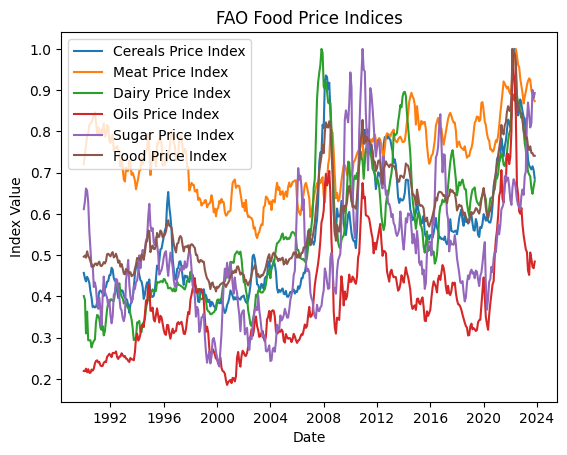

In [13]:
# Normalize each index based on its max value
data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index'].max()
data_dairy_price_index['Dairy Price Index'] = data_dairy_price_index['Dairy Price Index'] / data_dairy_price_index['Dairy Price Index'].max()
data_oil_price_index['Oils Price Index'] = data_oil_price_index['Oils Price Index'] / data_oil_price_index['Oils Price Index'].max()
data_sugar_price_index['Sugar Price Index'] = data_sugar_price_index['Sugar Price Index'] / data_sugar_price_index['Sugar Price Index'].max()
data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()

# Plot the normalized indices
plt.plot(data_cereal_price_index['Month'], data_cereal_price_index['Cereals Price Index'], label='Cereals Price Index')
plt.plot(data_meat_price_index['Month'], data_meat_price_index['Meat Price Index'], label='Meat Price Index')
plt.plot(data_dairy_price_index['Month'], data_dairy_price_index['Dairy Price Index'], label='Dairy Price Index')
plt.plot(data_oil_price_index['Month'], data_oil_price_index['Oils Price Index'], label='Oils Price Index')
plt.plot(data_sugar_price_index['Month'], data_sugar_price_index['Sugar Price Index'], label='Sugar Price Index')
plt.plot(data_food_price_index['Month'], data_food_price_index['Food Price Index'], label='Food Price Index')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('FAO Food Price Indices')
plt.ylabel('Index Value')
plt.xlabel('Date')
plt.legend()
plt.show()

**Export the Cleaned Data**

In [14]:
# if cleaned_data/food_indices does not exist, create it
if not os.path.exists('cleaned_data/food_indices'):
    os.makedirs('cleaned_data/food_indices')

data_cereal_price_index.to_csv('cleaned_data/food_indices/FAO_Cereal_Price_Index.csv')
data_meat_price_index.to_csv('cleaned_data/food_indices/FAO_Meat_Price_Index.csv')
data_dairy_price_index.to_csv('cleaned_data/food_indices/FAO_Dairy_Price_Index.csv')
data_oil_price_index.to_csv('cleaned_data/food_indices/FAO_Oil_Price_Index.csv')
data_sugar_price_index.to_csv('cleaned_data/food_indices/FAO_Sugar_Price_Index.csv')
data_food_price_index.to_csv('cleaned_data/food_indices/FAO_Food_Price_Index.csv')

### Part 1.3: Getting the Current Food Commodity Prices
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span>

The current value of different food commodities divided by country which is selling those food commodities. Choosing between food commodity pricing at the international, wholesale, or retail price point boils down to both the purpose and accuracy of this research. Respectively, this research aims to provide a model which can accurately predict the future price of food commodities for country food security, and more data (including futures data) is available at the international level. Therefore, the international price of food commodities is used as opposed to the other options.

**Data was pulled from the following website:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international

In [15]:
international_prices = pd.read_csv('all_data/International_Price_Data.csv')
international_prices['Date'] = pd.to_datetime(international_prices['Date'])
international_prices

,Date,"INTERNATIONAL PRICES, EXPORT, Argentina, Maize (Up River), USD/Kg","INTERNATIONAL PRICES, EXPORT, Argentina, Wheat (12%, Up River), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia, Meat: Bovine (Cow 90CL to US, f.a.s.), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia, Meat: Ovine (Medium trade lamb 18-20 Kg), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia (Eastern States), Barley (feed), USD/Kg","INTERNATIONAL PRICES, EXPORT, Australia (Eastern States), Wheat (ASW), USD/Kg","INTERNATIONAL PRICES, EXPORT, Bangladesh, Jute BWD (f.o.b. Mongla, at sight)/from 2006 Jute BTD (f.o.b Bangladesh Port), USD/Kg","INTERNATIONAL PRICES, EXPORT, Black Sea, Barley (feed), USD/Kg","INTERNATIONAL PRICES, EXPORT, Black Sea, Maize (feed), USD/Kg",...,"INTERNATIONAL PRICES, EXPORT, Unspecified, Rape oil (Dutch, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Rapeseed (Europe, 00, c.i.f. Hamburg), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Rapeseed meal (34%, Hamburg, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Soybean meal (44/45%, Hamburg, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Soybean oil (Dutch, f.o.b. ex-mill), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Sunflower oil (f.o.b. North West European Ports), USD/Kg","INTERNATIONAL PRICES, EXPORT, Unspecified, Sunflowerseed (EU, c.i.f. Amsterdam), USD/Kg","INTERNATIONAL PRICES, EXPORT, Uruguay, Rice (5% broken, long grain white, f.o.b., f.c.l.), USD/Kg","INTERNATIONAL PRICES, EXPORT, Viet Nam, Rice (25% broken), USD/Kg","INTERNATIONAL PRICES, EXPORT, Viet Nam, Rice (5% broken), USD/Kg"
0,2023-11-01,0.21320,0.25100,5.03689,2.72948,0.25185,0.27645,NaN,0.17495,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.77425,0.6080,0.63825
1,2023-10-01,0.22140,0.30420,5.13597,2.67446,0.25800,0.29632,0.71,0.17223,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74425,0.5890,0.60150
2,2023-09-01,0.23670,0.31305,5.17345,3.16106,0.25667,0.29829,0.73,0.18810,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73060,0.5870,0.60540
3,2023-08-01,0.22084,0.32176,5.02350,3.14367,0.24278,0.29365,0.70,0.18843,NaN,...,1.040,0.487,0.322,0.495,1.127,0.979,0.498,0.69725,0.5875,0.61425
4,2023-07-01,0.22740,0.33570,5.03421,3.33090,0.23433,0.29090,0.85,0.17733,0.1988,...,1.084,0.507,0.334,0.517,1.133,1.050,0.481,0.63425,0.4790,0.50400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,1990-05-01,NaN,NaN,2.25060,1.52462,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,1990-04-01,NaN,NaN,2.28440,1.44944,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,1990-03-01,NaN,NaN,2.27153,1.32313,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,1990-02-01,NaN,NaN,2.29281,1.37325,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Given each column is a country's individual food commodity market
commodity_item_trends = {} # {commodity: {country: prices df w/ date}}

for i,column_name in enumerate(international_prices.columns):
    if i > 0: # Not the "Date" column
        # Get the individual attributes from the column name
        attributes = column_name.split(', ')
        port_type = attributes[1] #import/export
        country = attributes[2]
        commodity = attributes[3]
        unit = attributes[4] # USD/kg, USD/tonne, etc...

        # Get the individual column series
        price_trend = international_prices[['Date', column_name]]
        price_trend['Port Type'] = port_type
        price_trend['Unit'] = unit
        price_trend.rename(columns={column_name: 'Price'}, inplace=True)


        # If the commodity has not been recorded yet...
        if commodity not in commodity_item_trends:
            commodity_item_trends[commodity] = {}
        # If the country has not been recorded yet...
        if country not in commodity_item_trends[commodity]:
            commodity_item_trends[commodity][country] = price_trend


C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\762702537.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Port Type'] = port_type
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\762702537.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Unit'] = unit
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\762702537.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [17]:
# Normalize each commodity's price trend
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        commodity_item_trends[commodity][country]['Price'] = commodity_item_trends[commodity][country]['Price'] / commodity_item_trends[commodity][country]['Price'].max()

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\873111579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_item_trends[commodity][country]['Price'] = commodity_item_trends[commodity][country]['Price'] / commodity_item_trends[commodity][country]['Price'].max()


In [18]:
# Plot all the countries' price trends for a given commodity
def plot_commodity_trends(commodity):
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]
        plt.plot(price_trend['Date'], price_trend['Price'], label=country)
        plt.gcf().set_size_inches(20, 5)
    plt.legend()
    plt.title(commodity)
    plt.xlabel('Price')
    plt.ylabel('Date')
    plt.show()

print(commodity_item_trends.keys())
commodity_item_trends['Wheat (12%']['Argentina']

dict_keys(['Maize (Up River)', 'Wheat (12%', 'Meat: Bovine (Cow 90CL to US', 'Meat: Ovine (Medium trade lamb 18-20 Kg)', 'Barley (feed)', 'Wheat (ASW)', 'Jute BWD (f.o.b. Mongla', 'Maize (feed)', 'Urea (N fertilizer)', 'Wheat (feed)', 'Wheat (milling', 'Meat: Bovine (Fresh', 'Meat: Pig meat (Meat of swine', 'Meat: Poultry (Meat and edible offal. Fresh', 'Sisal (Brazil Bahia', 'Wheat (CWRS', 'Potassium chloride', 'Bananas (US East Coast - Main Brands Central America', 'Bananas (US East Coast - Other Brands Central America', 'Bananas (US West Coast - Main Brands Central America', 'Bananas (US West Coast - Other Brands Central America', 'Sisal (East African', 'Dairy: Butter (European & Oceania average indicative export prices', 'Dairy: Cheddar Cheese (European & Oceania average indicative export prices', 'Dairy: Skim Milk Powder (European & Oceania average indicative export prices', 'Dairy: Whole Milk Powder (European & Oceania average indicative export prices', 'Wheat (grade 1', 'Meat: P

,Date,Price,Port Type,Unit
0,2023-11-01,0.524720,EXPORT,Up River)
1,2023-10-01,0.635936,EXPORT,Up River)
2,2023-09-01,0.654437,EXPORT,Up River)
3,2023-08-01,0.672646,EXPORT,Up River)
4,2023-07-01,0.701787,EXPORT,Up River)
...,...,...,...,...
402,1990-05-01,NaN,EXPORT,Up River)
403,1990-04-01,NaN,EXPORT,Up River)
404,1990-03-01,NaN,EXPORT,Up River)
405,1990-02-01,NaN,EXPORT,Up River)


#### Calculating the Residuals
Instead of going of previous commodity price datapoints, residuals from an overall weak trend can prove more useful to the training of a machine learning model, as supported by papers like [that written by Dr. Guerra Vallejos from MSOE](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=6FYxkMwAAAAJ&citation_for_view=6FYxkMwAAAAJ:zYLM7Y9cAGgC).

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\438364708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_trend['Trend'] = np.poly1d(np.polyfit(days, price_trend['Price'], 5))(days)


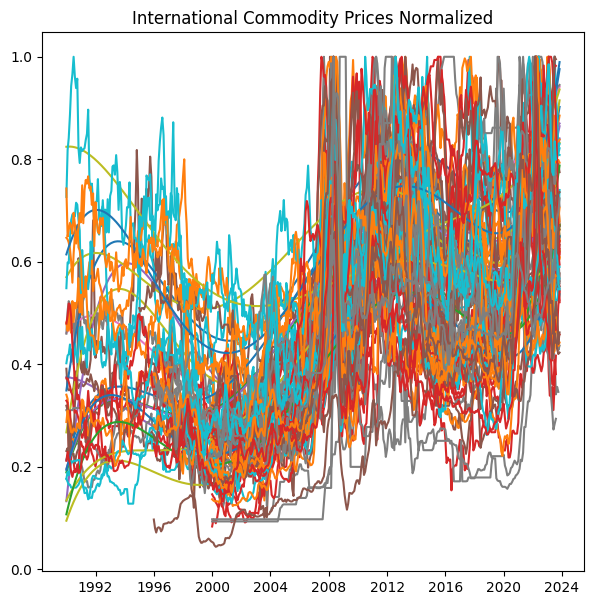

In [22]:
# Calculate the trend line (5th degree polynomial) for each commodity
plt.figure(figsize=(7,7))
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]
        days = (price_trend['Date'] - price_trend['Date'].min()).dt.days
        price_trend['Trend'] = np.poly1d(np.polyfit(days, price_trend['Price'], 5))(days)

        # Plot the trend line
        plt.plot(price_trend['Date'], price_trend['Trend'], label='Trend')
        plt.plot(price_trend['Date'], price_trend['Price'], label='Price')

plt.title('International Commodity Prices Normalized')
plt.show()

**Exporting the Cleaned Data**

In [193]:
# If cleaned_data/international_prices does not exist, create it
if not os.path.exists('cleaned_data/international_prices'):
    os.makedirs('cleaned_data/international_prices')

# Save each commodity's price trends to a csv file
for commodity in commodity_item_trends:
    for country in commodity_item_trends[commodity]:
        price_trend = commodity_item_trends[commodity][country]

        # Ensure there are no '/' in commodity or country
        commodity = commodity.replace('/', '-')
        country = country.replace('/', '-')

        price_trend.to_csv('cleaned_data/international_prices/{}_{}.csv'.format(commodity, country))

# Delete the extra files (Dairy, Meat)
for filename in os.listdir('cleaned_data/international_prices'):
    if filename.endswith('Dairy') or filename.endswith('Meat'):
        os.remove('cleaned_data/international_prices/{}'.format(filename))

### Part 1.4: Getting the Futures Trend Data
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span>

Futures are call options where traders estimate how the price will fluctuate in the future. The benefit to traders is that if they purchase a futures contract where the monetary value is less than the actual value at that time, the trader will purchase that commodity at a discount; however, the trader can cancel their contract if that actual value is lower than the contracted futures value. The benefit to the sellers is they will at least get the guaranteed premium income if the value of the commodity depreciates. Futures are important because they are currently the best indicator for how the traders believe the future of the market will perform in the short/medium term.

The futures data was pulled from Yahoo Finance. Based on the data available on this platform, the following futures data was pulled and will be used in the following analysis: sugar, corn, oat, wheat, rough rice, soybean oil, soybean, live cattle, coffee, and cotton. For individual download links to each of these datasets, please see the `Part 1: Data Collection` section of this notebook.

In [261]:
cocoa_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Cocoa_Futures.csv').dropna()
coffee_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Coffee_Futures.csv').dropna()
corn_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Corn_Futures.csv').dropna()
cotton_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Cotton_Futures.csv').dropna()
live_cattle_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Live-Cattle_Futures.csv').dropna()
oat_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Oat_Futures.csv').dropna()
rough_rice_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Rough-Rice_Futures.csv').dropna()
soybean_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Soybean_Futures.csv').dropna()
soybean_oil_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Soybean-Oil_Futures.csv').dropna()
wheat_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Wheat_Futures.csv').dropna()
sugar_futures = pd.read_csv('all_data/Yahoo_Finance_Futures_Data/International_Sugar_Futures.csv').dropna()

In [262]:
# Convert all the dates to datetime objects
cocoa_futures['Date'] = pd.to_datetime(cocoa_futures['Date']).dt.date
coffee_futures['Date'] = pd.to_datetime(coffee_futures['Date']).dt.date
corn_futures['Date'] = pd.to_datetime(corn_futures['Date']).dt.date
cotton_futures['Date'] = pd.to_datetime(cotton_futures['Date']).dt.date
live_cattle_futures['Date'] = pd.to_datetime(live_cattle_futures['Date']).dt.date
oat_futures['Date'] = pd.to_datetime(oat_futures['Date']).dt.date
rough_rice_futures['Date'] = pd.to_datetime(rough_rice_futures['Date']).dt.date
soybean_futures['Date'] = pd.to_datetime(soybean_futures['Date']).dt.date
soybean_oil_futures['Date'] = pd.to_datetime(soybean_oil_futures['Date']).dt.date
wheat_futures['Date'] = pd.to_datetime(wheat_futures['Date']).dt.date
sugar_futures['Date'] = pd.to_datetime(sugar_futures['Date']).dt.date
cocoa_futures

,Date,Open,High,Low,Close,% Change,% Change vs Average,Volume
0,2000-01-01,840.00,875.00,757.00,763.00,0.00,-1.01,"97,087"
1,2000-02-01,775.00,805.00,730.00,759.00,-0.52,-1.53,"64,590"
2,2000-03-01,770.00,929.00,770.00,800.00,5.40,4.40,"64,659"
3,2000-04-01,785.00,850.00,740.00,764.00,-4.50,-5.51,"56,738"
4,2000-05-01,784.00,874.00,743.00,848.00,10.99,9.99,"57,609"
...,...,...,...,...,...,...,...,...
282,2023-07-01,"3,306.00","3,602.00","3,230.00","3,543.00",6.78,5.77,"301,797"
283,2023-08-01,"3,538.00","3,652.00","3,237.00","3,574.00",0.87,-0.13,"324,408"
284,2023-09-01,"3,638.00","3,874.00","3,398.00","3,418.00",-4.36,-5.37,"277,923"
285,2023-10-01,"3,432.00","3,880.00","3,373.00","3,794.00",11.00,9.99,"473,960"


In [263]:
# Convert the 'High' and 'Low' columns to numeric
for column_name in ['High', 'Low', 'Open', 'Close', 'Volume']:
    cocoa_futures[column_name] = pd.to_numeric(cocoa_futures[column_name].astype(str).str.replace(',', ''))
    coffee_futures[column_name] = pd.to_numeric(coffee_futures[column_name].astype(str).str.replace(',', ''))
    corn_futures[column_name] = pd.to_numeric(corn_futures[column_name].astype(str).str.replace(',', ''))
    cotton_futures[column_name] = pd.to_numeric(cotton_futures[column_name].astype(str).str.replace(',', ''))
    live_cattle_futures[column_name] = pd.to_numeric(live_cattle_futures[column_name].astype(str).str.replace(',', ''))
    oat_futures[column_name] = pd.to_numeric(oat_futures[column_name].astype(str).str.replace(',', ''))
    rough_rice_futures[column_name] = pd.to_numeric(rough_rice_futures[column_name].astype(str).str.replace(',', ''))
    soybean_futures[column_name] = pd.to_numeric(soybean_futures[column_name].astype(str).str.replace(',', ''))
    soybean_oil_futures[column_name] = pd.to_numeric(soybean_oil_futures[column_name].astype(str).str.replace(',', ''))
    wheat_futures[column_name] = pd.to_numeric(wheat_futures[column_name].astype(str).str.replace(',', ''))
    sugar_futures[column_name] = pd.to_numeric(sugar_futures[column_name].astype(str).str.replace(',', ''))

In [264]:
# Calculate an 'Average' column for each futures df based on the 'High' and 'Low' columns
cocoa_futures['Average'] = (cocoa_futures['High'] + cocoa_futures['Low']) / 2
coffee_futures['Average'] = (coffee_futures['High'] + coffee_futures['Low']) / 2
corn_futures['Average'] = (corn_futures['High'] + corn_futures['Low']) / 2
cotton_futures['Average'] = (cotton_futures['High'] + cotton_futures['Low']) / 2
live_cattle_futures['Average'] = (live_cattle_futures['High'] + live_cattle_futures['Low']) / 2
oat_futures['Average'] = (oat_futures['High'] + oat_futures['Low']) / 2
rough_rice_futures['Average'] = (rough_rice_futures['High'] + rough_rice_futures['Low']) / 2
soybean_futures['Average'] = (soybean_futures['High'] + soybean_futures['Low']) / 2
soybean_oil_futures['Average'] = (soybean_oil_futures['High'] + soybean_oil_futures['Low']) / 2
wheat_futures['Average'] = (wheat_futures['High'] + wheat_futures['Low']) / 2
sugar_futures['Average'] = (sugar_futures['High'] + sugar_futures['Low']) / 2
wheat_futures

,Date,Open,High,Low,Close,% Change,% Change vs Average,Volume,Average
0,2002-11-24,423.00,434.00,422.50,432.75,2.00,1.87,13415,428.250
1,2002-12-01,440.00,441.00,396.00,404.00,-6.64,-6.77,2555,418.500
2,2002-12-08,396.00,401.00,390.50,399.50,-1.11,-1.24,288,395.750
3,2002-12-15,404.25,408.50,372.00,377.25,-5.57,-5.70,11008,390.250
4,2002-12-22,377.00,384.00,366.25,370.50,-1.79,-1.92,12787,375.125
...,...,...,...,...,...,...,...,...,...
1096,2023-11-26,602.50,646.75,587.50,645.00,7.14,7.01,33793,617.125
1097,2023-12-03,644.75,673.00,644.75,655.75,1.67,1.54,212,658.875
1098,2023-12-10,627.00,662.00,626.75,642.75,-1.98,-2.11,41908,644.375
1099,2023-12-17,643.50,644.75,619.25,623.00,-3.07,-3.20,99769,632.000


In [265]:
# For each month/year, calculate the average price of each commodity

cocoa_futures['Date'] = pd.to_datetime(cocoa_futures['Date']); cocoa_futures['Month'] = cocoa_futures['Date'].dt.month; cocoa_futures['Year'] = cocoa_futures['Date'].dt.year
cocoa_futures = cocoa_futures.groupby(['Year', 'Month']).mean()

coffee_futures['Date'] = pd.to_datetime(coffee_futures['Date']); coffee_futures['Month'] = coffee_futures['Date'].dt.month; coffee_futures['Year'] = coffee_futures['Date'].dt.year
coffee_futures = coffee_futures.groupby(['Year', 'Month']).mean()

corn_futures['Date'] = pd.to_datetime(corn_futures['Date']); corn_futures['Month'] = corn_futures['Date'].dt.month; corn_futures['Year'] = corn_futures['Date'].dt.year
corn_futures = corn_futures.groupby(['Year', 'Month']).mean()

cotton_futures['Date'] = pd.to_datetime(cotton_futures['Date']); cotton_futures['Month'] = cotton_futures['Date'].dt.month; cotton_futures['Year'] = cotton_futures['Date'].dt.year
cotton_futures = cotton_futures.groupby(['Year', 'Month']).mean()

live_cattle_futures['Date'] = pd.to_datetime(live_cattle_futures['Date']); live_cattle_futures['Month'] = live_cattle_futures['Date'].dt.month; live_cattle_futures['Year'] = live_cattle_futures['Date'].dt.year
live_cattle_futures = live_cattle_futures.groupby(['Year', 'Month']).mean()

oat_futures['Date'] = pd.to_datetime(oat_futures['Date']); oat_futures['Month'] = oat_futures['Date'].dt.month; oat_futures['Year'] = oat_futures['Date'].dt.year
oat_futures = oat_futures.groupby(['Year', 'Month']).mean()

rough_rice_futures['Date'] = pd.to_datetime(rough_rice_futures['Date']); rough_rice_futures['Month'] = rough_rice_futures['Date'].dt.month; rough_rice_futures['Year'] = rough_rice_futures['Date'].dt.year
rough_rice_futures = rough_rice_futures.groupby(['Year', 'Month']).mean()

soybean_futures['Date'] = pd.to_datetime(soybean_futures['Date']); soybean_futures['Month'] = soybean_futures['Date'].dt.month; soybean_futures['Year'] = soybean_futures['Date'].dt.year
soybean_futures = soybean_futures.groupby(['Year', 'Month']).mean()

soybean_oil_futures['Date'] = pd.to_datetime(soybean_oil_futures['Date']); soybean_oil_futures['Month'] = soybean_oil_futures['Date'].dt.month; soybean_oil_futures['Year'] = soybean_oil_futures['Date'].dt.year
soybean_oil_futures = soybean_oil_futures.groupby(['Year', 'Month']).mean()

wheat_futures['Date'] = pd.to_datetime(wheat_futures['Date']); wheat_futures['Month'] = wheat_futures['Date'].dt.month; wheat_futures['Year'] = wheat_futures['Date'].dt.year
wheat_futures = wheat_futures.groupby(['Year', 'Month']).mean()

sugar_futures['Date'] = pd.to_datetime(sugar_futures['Date']); sugar_futures['Month'] = sugar_futures['Date'].dt.month; sugar_futures['Year'] = sugar_futures['Date'].dt.year
sugar_futures = sugar_futures.groupby(['Year', 'Month']).mean()



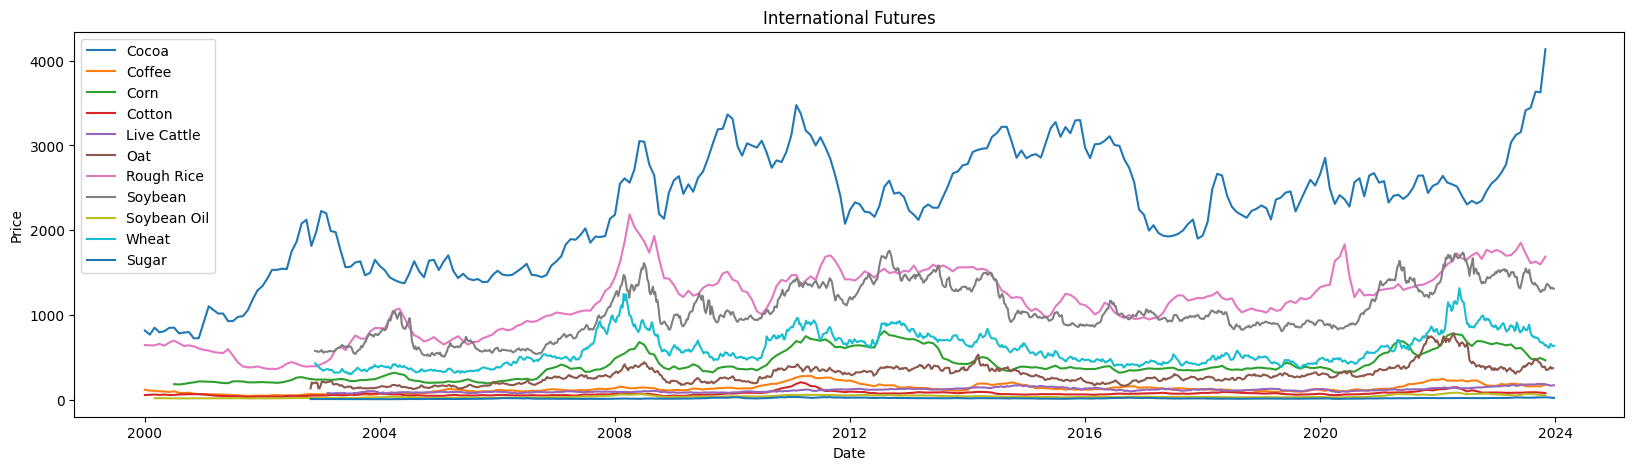

In [247]:
# Plot the average price for each future
plt.plot(cocoa_futures['Date'], cocoa_futures['Average'], label='Cocoa')
plt.plot(coffee_futures['Date'], coffee_futures['Average'], label='Coffee')
plt.plot(corn_futures['Date'], corn_futures['Average'], label='Corn')
plt.plot(cotton_futures['Date'], cotton_futures['Average'], label='Cotton')
plt.plot(live_cattle_futures['Date'], live_cattle_futures['Average'], label='Live Cattle')
plt.plot(oat_futures['Date'], oat_futures['Average'], label='Oat')
plt.plot(rough_rice_futures['Date'], rough_rice_futures['Average'], label='Rough Rice')
plt.plot(soybean_futures['Date'], soybean_futures['Average'], label='Soybean')
plt.plot(soybean_oil_futures['Date'], soybean_oil_futures['Average'], label='Soybean Oil')
plt.plot(wheat_futures['Date'], wheat_futures['Average'], label='Wheat')
plt.plot(sugar_futures['Date'], sugar_futures['Average'], label='Sugar')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('International Futures')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

**Export the Cleaned Data**

In [266]:
# If 'cleaned_data/futures' does not exist, create it
if not os.path.exists('cleaned_data/futures'):
    os.makedirs('cleaned_data/futures')

# Save the csv data
cocoa_futures.to_csv('cleaned_data/futures/ICE_Cocoa_Futures.csv')
coffee_futures.to_csv('cleaned_data/futures/ICE_Coffee_Futures.csv')
corn_futures.to_csv('cleaned_data/futures/CBOT_Corn_Futures.csv')
cotton_futures.to_csv('cleaned_data/futures/ICE_Cotton_Futures.csv')
live_cattle_futures.to_csv('cleaned_data/futures/CME_Live-Cattle_Futures.csv')
oat_futures.to_csv('cleaned_data/futures/CBOT_Oat_Futures.csv')
rough_rice_futures.to_csv('cleaned_data/futures/CBOT_Rough-Rice_Futures.csv')
soybean_futures.to_csv('cleaned_data/futures/CBOT_Soybean_Futures.csv')
soybean_oil_futures.to_csv('cleaned_data/futures/CBOT_Soybean-Oil_Futures.csv')
wheat_futures.to_csv('cleaned_data/futures/CBOT_Wheat_Futures.csv')
sugar_futures.to_csv('cleaned_data/futures/ICE_Sugar_Futures.csv')

### Part 1.5: Getting the Harvest Data
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span>

Harvest data is important for predicting the actual price of food commodities in the future, as it is a direct indicator of the supply of food commodities. The more food commodities available, the lower the price will be. This data is also important because it can be used to determine the overall trend of the market, as well as the overall trend of the market in a specific country.
* **Crops and Livestock Products:** https://www.fao.org/faostat/en/#data/QCL; 
* **Value of Agricultural Production:** https://www.fao.org/faostat/en/#data/QV; Values of agricultural production are calculated based on production data of primary commodities from Production domain and producer prices from Prices domain. The livestock value of production is measured in terms of indigenous meat. **WHAT WILL BE USED**
* **Production Indices:** https://www.fao.org/faostat/en/#data/QI; The FAO indices of agricultural production show the relative level of the aggregate volume of agricultural production for each year in comparison with the base period 2014-2016. Indices for meat production are computed based on data for production from indigenous animals.

Note, this data is already normalized by the FAO.

In [43]:
production_data = pd.read_csv('all_data/Value_of_Production_E_All_Data_(Normalized)/Value_of_Production_E_All_Data_(Normalized).csv', encoding='ISO-8859-1')
production_data = production_data[['Area', 'Item', 'Element', 'Year', 'Unit', 'Value', 'Flag']]
production_data

,Area,Item,Element,Year,Unit,Value,Flag
0,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1976,1000 Int. $,49550.0,E
1,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1977,1000 Int. $,45505.0,E
2,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1978,1000 Int. $,60673.0,E
3,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1979,1000 Int. $,53089.0,E
4,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1980,1000 Int. $,50055.0,E
...,...,...,...,...,...,...,...
2793884,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2017,1000 US$,24659857.0,E
2793885,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2018,1000 US$,25312231.0,E
2793886,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2019,1000 US$,25924331.0,E
2793887,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2020,1000 US$,27170537.0,E


In [44]:
flag_lookup_table = pd.read_csv('all_data/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_Flags.csv', encoding='ISO-8859-1')
flag_lookup_table

,Flag,Description
0,A,Official figure
1,E,Estimated value
2,I,Imputed value
3,M,Missing value (data cannot exist; not applicable)
4,X,Figure from international organizations


In [45]:
# Merge the production_data and flag_lookup_table dataframes
production_data = production_data.merge(flag_lookup_table, on='Flag', how='left')

# Drop the 'Flag' column and rename the 'Description' column to 'Flag'
production_data.drop(columns=['Flag'], inplace=True)
production_data.rename(columns={'Description': 'Flag'}, inplace=True)
production_data

,Area,Item,Element,Year,Unit,Value,Flag
0,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1976,1000 Int. $,49550.0,Estimated value
1,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1977,1000 Int. $,45505.0,Estimated value
2,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1978,1000 Int. $,60673.0,Estimated value
3,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1979,1000 Int. $,53089.0,Estimated value
4,Afghanistan,"Almonds, in shell",Gross Production Value (constant 2014-2016 tho...,1980,1000 Int. $,50055.0,Estimated value
...,...,...,...,...,...,...,...
2793884,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2017,1000 US$,24659857.0,Estimated value
2793885,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2018,1000 US$,25312231.0,Estimated value
2793886,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2019,1000 US$,25924331.0,Estimated value
2793887,Net Food Importing Developing Countries,Vegetables Primary,Gross Production Value (constant 2014-2016 tho...,2020,1000 US$,27170537.0,Estimated value


In [53]:
# Divide up the production_data by Item
production_data_by_item = {} # {commodity: {country: prices df w/ date}}

for i,row in production_data.iterrows():
    item = row['Item']
    country = row['Area']

    # Remove all "'" from item name
    item = item.replace("'", "")

    # If the item has not been recorded yet...
    if item not in production_data_by_item:
        production_data_by_item[item] = {}
    # If the country has not been recorded yet...
    if country not in production_data_by_item[item]:
        df = production_data[(production_data['Item'] == item) & (production_data['Area'] == country)]
        production_data_by_item[item][country] = df

In [56]:
# Plot all the countries' price trends for a given commodity
def plot_production_trends(item):
    for country in production_data_by_item[item]:
        production_trend = production_data_by_item[item][country]
        plt.plot(production_trend['Year'], production_trend['Value'], label=country)
        plt.gcf().set_size_inches(20, 5)
    plt.legend()
    plt.title(item)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

print(production_data_by_item.keys())

dict_keys(['Almonds, in shell', 'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw', 'Apples', 'Apricots', 'Barley', 'Cantaloupes and other melons', 'Figs', 'Game meat, fresh, chilled or frozen', 'Grapes', 'Hen eggs in shell, fresh', 'Linseed', 'Maize (corn)', 'Meat of camels, fresh or chilled (indigenous)', 'Meat of cattle with the bone, fresh or chilled (indigenous)', 'Meat of chickens, fresh or chilled (indigenous)', 'Meat of goat, fresh or chilled (indigenous)', 'Meat of sheep, fresh or chilled (indigenous)', 'Millet', 'Natural honey', 'Olives', 'Onions and shallots, dry (excluding dehydrated)', 'Oranges', 'Other berries and fruits of the genus vaccinium n.e.c.', 'Other citrus fruit, n.e.c.', 'Other fruits, n.e.c.', 'Other nuts (excluding wild edible nuts and groundnuts), in shell, n.e.c.', 'Other pulses n.e.c.', 'Other stimulant, spice and aromatic crops, n.e.c.', 'Other stone fruits', 'Other vegetables, fresh n.e.c.', 'Peaches and nectarines', 'Pears', 'Pi

**Export the Cleaned Data**

In [ ]:
# Save the production_data_by_item to individual csv files

# If cleaned_data/production_data does not exist, create it
if not os.path.exists('cleaned_data/production_data'):
    os.makedirs('cleaned_data/production_data')

for item in production_data_by_item:
    for country in production_data_by_item[item]:
        df = production_data_by_item[item][country]

        # Ensure there are no '/' in commodity or country
        item = item.replace('/', '-')
        country = country.replace('/', '-')

        df.to_csv('cleaned_data/production_data/{}_{}.csv'.format(item, country))

### Part 1.6: Getting the Articles & Article Sentiment
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span><br/>
<span style="color: orange;">**Possible Future Update:** Pull more articles for sentiment analysis; perhaps by country/commodity.</span>


Different articles submitted by credible economic platforms can be used as part of the model's predictions for the future market, as well as even social media to capture public sentiment ([as shown in this paper](https://arxiv.org/pdf/2310.18706.pdf)). Sentiment of these articles is an effective, efficient method of processing large amounts of text for stock predictions. A research paper outlining the effectiveness of utilizing sentiment for stock prediction can be found [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3649137)

Therefore, in order to get the sentiment of these articles (listed at the beginning of `Part 1: Data Collection`), a Sentiment Analysis model specializing in large-document sentiment analysis will be downloaded from Hugging Face and varying, professional sources/articles will be parseed. The sentiment model that will be used is: [distilroberta-finetuned-financial-news-sentiment-analysis](https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis). This model was chosen both for its ability to parse larger corpora of text and its ability to parse financial information accurately.

As for specific documents used in this dataset, the following documents were used:
* **FAO Agricultural Outlook:** https://www.fao.org/documents/card/en/c/cc6361en
    * [2023-2032](https://www.fao.org/documents/card/en/c/cc6361en), [2022-2031](http://www.fao.org/documents/card/en/c/cc0308en), [2021-2030](http://www.fao.org/documents/card/en/c/cb5332en), [2020-2029](https://www.fao.org/documents/card/en/c/ca8861en), [2019-2028](http://www.fao.org/documents/card/en/c/ca4076en), [2018-2027](http://www.fao.org/documents/card/en/c/i9166en), [2017-2026](https://www.fao.org/documents/card/en/c/9063b6e9-e46e-463e-86bd-8cb3ec477d31), [2016-2025](https://www.fao.org/documents/card/en/c/f0589695-58d9-425c-8be2-7dc065e5602f), [2015-2024](https://www.fao.org/documents/card/en/c/3db5270d-5f6c-4e82-9f1f-f03b3650d51c)
    * **NOTE:** Each of these documents contains an executive summary which can be used to reduce data complexity and processing time.
* **FAO Food Outlook:** https://www.fao.org/documents/card/en/c/cb4471en  
* **FAO Social Media:** https://twitter.com/FAO


In [59]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

c:\Users\paulsonb\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\paulsonb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [145]:
# Read through all the pdfs stored in the 'all_data/Econmic_PDFs' directory and extract their text into a dictionary
pdfs = {} # {'filename': ['text', 'sentiment']}

def determine_pdf_sentiment(directory = 'all_data/Economic_PDFs'):
    """
    Given a directory of pdfs, determine the sentiment of each pdf and store it in a dictionary
    :param directory: the directory containing the pdfs
    """
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_file = open('{}/{}'.format(directory, filename), 'rb')
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            pdf_text = ''

            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                pdf_text += page.extract_text()

            # Determine the sentiment of the document
            tokenized_text = tokenizer(pdf_text, return_tensors="pt", truncation=True, padding=True)
            outputs = model(**tokenized_text)

            # Based on the logit output, determine correlating sentiment
            probabilities = F.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            sentiment = "positive" if prediction.item() == 1 else "negative"
            print("File ", filename, " is sentiment: ", sentiment)

            pdfs[filename] = [pdf_text, sentiment]

In [146]:
determine_pdf_sentiment()

File  2000_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2001_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2002_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2003-04_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2005_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2006_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2007_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2008_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2009_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2010-11_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2012_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2013_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2014_State-of-Food-and-Agriculture.pdf  is sentiment:  positive
File  2015_State-of-Food-and-Agriculture.pdf  is sentiment:  negative
File  2016_Sta

In [286]:
# Based on the pdfs dictionary, create a csv file with the columns 'File Name' and 'Sentiment'
pdf_sentiment_df = pd.DataFrame.from_dict(pdfs, orient='index', columns=['Text', 'Sentiment'])
pdf_sentiment_df.index.name = 'File Name'

# Convert the index to the column 'File Name'
pdf_sentiment_df.reset_index(inplace=True)

# Make the sentiment 1 for positive and -1 for negative
pdf_sentiment_df['Sentiment'] = pdf_sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1)
pdf_sentiment_df['Year'] = pdf_sentiment_df['File Name'].apply(lambda x: int(x[:4]))

**Export the Cleaned Data**

In [288]:
# Make the pdf_sentiment directory if it does not exist
if not os.path.exists('cleaned_data/pdf_sentiment'):
    os.makedirs('cleaned_data/pdf_sentiment')

pdf_sentiment_df.to_csv('cleaned_data/pdf_sentiment/State_of_Food_and_Agriculture.csv')

### Part 1.7: Bringing in the Broader Discussion (Twitter)
<span style="color: red;">**This section only needs to be ran once; check the `cleaned_data` folder for if you already have this data.**</span><br/>
<span style="color: red;">**MUST BE GRADUATE-LEVEL OR HIGHER AND APPROVED BY TWITTER TO GET TWEETS MORE THAN 7 DAYS OLD**</span><br/>

The broader discussion of food security and food prices can be found on Twitter, with different announcements released by the government-affiliated accounts of each ISO. This data was built semi-automatically by using CoPilot to pull the government affiliated tags in `twitter_data.csv`. Then, the Twitter API, credentials included in `twitter_api_key.txt`, was used to pull the tweets from the government-affiliated accounts. The data was then cleaned and exported to `cleaned_data/twitter_data.csv`.

[This tutorial](https://huggingface.co/blog/sentiment-analysis-twitter) was followed to understand how the Twitter API works and how it can be used for ML research.

In [100]:
# !pip install -q transformers tweepy matplotlib wordcloud

import tweepy

In [109]:
# Never put your key as a literal
twitter_api_key = '' 
twitter_api_key_secret = ''
twitter_bearer_token = '' 
twitter_access_token = '' 
twitter_access_token_secret = '' 

# Open the text file
with open('./twitter_api_key.txt', 'r') as file:
    # Read each line in the file
    for line in file:
        if 'API Key: ' in line:
            twitter_api_key = line.replace('API Key: ', '')
            twitter_api_key = twitter_api_key.replace('\n', '')
        elif 'API Key Secret: ' in line:
            twitter_api_key_secret = line.replace('API Key Secret: ', '')
            twitter_api_key_secret = twitter_api_key_secret.replace('\n', '')
        elif 'Bearer Token: ' in line:
            twitter_bearer_token = line.replace('Bearer Token: ', '')
            twitter_bearer_token = twitter_bearer_token.replace('\n', '')
        elif 'Access Token: ' in line:
            twitter_access_token = line.replace('Access Token: ', '')
            twitter_access_token = twitter_access_token.replace('\n', '')
        elif 'Access Token Secret: ' in line:
            twitter_access_token_secret = line.replace('Access Token Secret: ', '')
            twitter_access_token_secret = twitter_access_token_secret.replace('\n', '')

In [113]:
auth = tweepy.OAuth2BearerHandler(twitter_bearer_token)
api = tweepy.API(auth)

### Part 1.8: International Monetary Fund
The International Monetary Fund provides a plethora of data on the world's economy, including the world's food economy. This data can be found at the [IMF Datasets](https://data.imf.org/?sk=388DFA60-1D26-4ADE-B505-A05A558D9A42&sId=1479329132316) webpage. This data can be used to determine the overall trend of the world's economy, as well as the overall trend of the world's food economy.

**Specifically, we are interested in data which could provide signal for accurately determining commodity price. Here are the following datasets which were pulled (along with definitions from the IMF website):**
* `Consumer Price Index (CPI)`: Consumer Price Indexes (CPIs) are index numbers that measure changes int he prices of goods and services prucahsed or otherwise acquired by households, which are used to estimate the cost of living.
* `Primary Commodity Price System (PCPS)`: Indices in terms of dollars or sdrs, indices of market prices for non-fuel commodities and petroleum, actual market prices for non-fuel commodities and petroleum, and average weekly rpices for non-fuel commodities and petroleum.
* `International Financial Statistics (IFS)`: The International Financial Statistics database covers about 200 countreis and areas, with some aggregates calculated for selected regions, plus some world totals. Toipcs ccovered include balance payments, commodity prices, exchange rates, fund position, government finance, industrial production,, intereste rates, international investment position, international liquiddity, international transactions, labor statitistics, money and banking, national accounts, populations, prices ,and real effective exchange rates.
* `Financial Soundness Indicators (FSIs)`: The Financial Soundness Indicators (FSIs), developed by the IMF together with the international community, are aimed at supporting macroproduential analysis -- the surveillance and assessment of the strength and vulnerabilities of financial systems. FSIs are macroprudential statisitcs aimed at filling the gap between macroeconomic statstics and micro-prudential data.

#### Part 1.8a: Consumer Price Index (CPI)

In [135]:
cpi_data = pd.read_csv('all_data/international_monetary_fund/CPI/CPI_02-18-2024 18-47-45-93_panel.csv', low_memory=False)

In [153]:
# Create a dictionary of dataframes for each country
cpi_data_by_country = {} # {country: df}

for i,row in cpi_data.iterrows():
    country = row['Country Name']
    if country not in cpi_data_by_country:
        cpi_data_by_country[country] = cpi_data[cpi_data['Country Name'] == country]

        # Remove rows where the 'Time Period' column does not contain the letter "M"
        cpi_data_by_country[country] = cpi_data_by_country[country][cpi_data_by_country[country]['Time Period'].str.contains('M')]

        # Convert the 'Time Period' column to a datetime object (the format is '<year>M<number>')
        cpi_data_by_country[country]['Time Period'] = cpi_data_by_country[country]['Time Period'].apply(lambda x: pd.to_datetime(x.replace('M', '-')))
        cpi_data_by_country[country].sort_values(by='Time Period', inplace=True)


In [157]:
# Export the dataframes to csv files in cleaned_data
if not os.path.exists('cleaned_data/international_monetary_fund'):
    os.makedirs('cleaned_data/international_monetary_fund')
if not os.path.exists('cleaned_data/international_monetary_fund/cpi'):
    os.makedirs('cleaned_data/international_monetary_fund/cpi')

for country in cpi_data_by_country:
    cpi_data_by_country[country].to_csv('cleaned_data/international_monetary_fund/cpi/{}.csv'.format(country))

In [284]:
pd.read_csv('cleaned_data/international_monetary_fund/cip/Norway.csv')

NameError: name 'cpi_data_by_country' is not defined

### Part 1.9: Building a Finalized Dataframe
The finalized dataframe will be used to easily understand which variables are reserved for input/output alongside the associated date as a transformer is trained to learn the time series patterns. Manipulating the data into this dataframe will also allow for easy data visualization and analysis in the next section (`Part 2: Statistical Analysis`) of this notebook analysis. Here is a breakdown of the final dataframe(s):

* **Output Variable:**
    * International Prices (particular `commodity`, `country`, `month`, `unit`); `cleaned_data/international_prices/`
* **Input Variables:**
    * PROTEUS Index (particular `year`, `country`); `PROTEUS_Index_data.csv`
    * Food Price Indices (particular `index` (industry), `month`); `cleaned_data/food_indices/`
    * Futures Data (particular `commodity`, `month`); `cleaned_data/futures/`
    * Harvest Data (particular `commodity`, `region/country`, `year`); `cleaned_data/production_data/`
    * Sentiment (particular `year`); see `Part 1.6` for more info

**NOTE:** As outlined in [Dr. Guerra Vallejos' research](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=6FYxkMwAAAAJ&citation_for_view=6FYxkMwAAAAJ:zYLM7Y9cAGgC), trend-prediction models tend to perform better when calculating the difference between the global trend and the actual price of a commodity (the residual). Therefore, all numerical features will be converted to a residual format (prior to normalization between 0 and 1), as you can see in the following graphic:<br/>
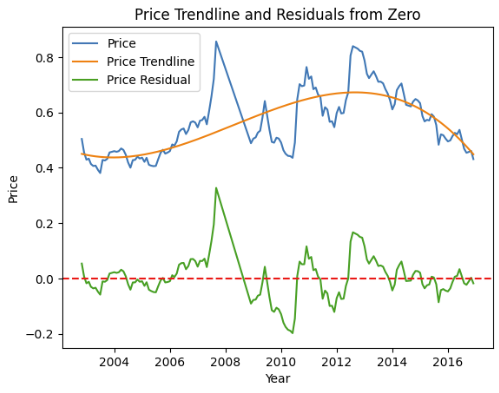


In [55]:
def transform_model_data_to_trend(model_data, degree = 3, verbose = False):
    """
    Given the model data dataframe, transform the data so all numerical
    features are the residuals from a weak trendline. The trendline is
    determine from Dr. Guerra Vallejo's previous work on the topic of
    weak trend lines for price prediction; see below:
    https://scholar.google.com/citations?view_op=view_citation&hl=en&user=6FYxkMwAAAAJ&citation_for_view=6FYxkMwAAAAJ:zYLM7Y9cAGgC

    Approach Outline:
        1.) Ensure we have time-series data (i.e. 'Date' column)
        2.) Determine a weak trendline based by year on the data
        3.) Calculate the residuals from the trend for each feature
        4.) Return the transformed data

    :param model_data: the dataframe containing the model data
    :param degree: the degree of the polynomial for the trendline

    :return: the transformed model data
    """
    # Ensure we have time-series data
    if 'Date' not in model_data.columns:
        raise ValueError('The model data does not contain a "Date" column')

    # Calculate the trendline and the residuals for each feature (from the weak trendline)
    days = (model_data['Date'] - model_data['Date'].min()).dt.days
    for feature in model_data.columns:
        if feature != 'Date' and feature != 'Sentiment':
            coefficients = np.polyfit(days, model_data[feature], degree)
            p = np.poly1d(coefficients)
            model_data[f'{feature}_trendline'] = p(days)
            model_data[f'{feature}_residual'] = model_data[feature] - p(days)
    
            # Plot the trendline and the residuals (also plot a dashed, red line on the x-axis for reference)
            if verbose:
                plt.plot(model_data['Date'], model_data['Price'], label='Price')   
                plt.plot(model_data['Date'], model_data['Price_trendline'], label='Price Trendline')
                plt.plot(model_data['Date'], model_data['Price_residual'], label='Price Residual')
                plt.axhline(0.5, color='red', linestyle='--')
                plt.xlabel('Year')
                plt.ylabel('Price')
                plt.title('Price Trendline and Residuals from Zero')
                plt.legend()
                plt.show()

            # Save the data in its final format
            model_data[feature] = model_data[f'{feature}_residual']
            model_data.drop(columns=[f'{feature}_trendline', f'{feature}_residual'], inplace=True) 

    # Normalize all features to between 1 and 0 (note, some values are negative)
    for feature in model_data.columns:
        if feature != 'Date' and feature != 'Sentiment':
            model_data[feature] = (model_data[feature] - model_data[feature].min()) / (model_data[feature].max() - model_data[feature].min())

    return model_data

In [63]:
def pull_model_data(iso, commodity_file, special_index_file, futures_file, harvest_file):
    """
    Given particular file names, format the data into a dataframe for easy
    statistical analysis in the next section and easy ML input
    :param str iso: The iso of the country (ARG, USA, etc...); for PROTEUS data
    :param str commodity_file: Name of the file containing the commodity pricing data
    :param str special_index_file: The other index (other than general food index) used for this commodity
    :para str futures_file: The related futures of this commodity
    :param str harvest_file: The related harvest data of this commodity
    :return: A dataframe containing all the data
    """
    ### Pulling the data
    commodity_price_data = pd.read_csv('cleaned_data/international_prices/{}'.format(commodity_file))
    commodity_price_data['Date'] = pd.to_datetime(commodity_price_data['Date'])
    commodity_price_data['Month'] = commodity_price_data['Date'].dt.month
    commodity_price_data['Year'] = commodity_price_data['Date'].dt.year
    commodity_price_data.drop(columns=['Unnamed: 0'], inplace=True)
    print("Commody Price Data Shape: ", commodity_price_data.shape)

    proteus_data = pd.read_csv('cleaned_data/PROTEUS_Index_data.csv')
    proteus_data = proteus_data[proteus_data['Iso'] == iso]

    food_index_data = pd.read_csv('cleaned_data/food_indices/FAO_Food_Price_Index.csv')
    special_index_data = pd.read_csv('cleaned_data/food_indices/{}'.format(special_index_file))
    futures_data = pd.read_csv('cleaned_data/futures/{}'.format(futures_file))
    harvest_data = pd.read_csv('cleaned_data/production_data/{}'.format(harvest_file))
    fao_agriculture_sentiment_data = pd.read_csv('cleaned_data/pdf_sentiment/State_of_Food_and_Agriculture.csv')

    ### Merging the data
    # Merge the dataframes based on Date/Year
    model_data = commodity_price_data.merge(proteus_data, on='Year', how='left')
    model_data = model_data.dropna(subset=['Price', 'Proteus2']) # Some PROTEUS/Price data may not be available for certain years; drop it
    print("Shape Progress 1: ", model_data.shape)

    if model_data.shape[0] == 0:
        print("== WARNING: Likely no PROTEUS data for the years where this country recorded price data for this commodity ==")

    # Merge the Food-Index data and Cereal-Index data based on Date
    food_index_data['Date'] = pd.to_datetime(food_index_data['Month']); food_index_data.drop(columns=['Unnamed: 0', 'Month'], inplace=True)
    special_index_data['Date'] = pd.to_datetime(special_index_data['Month']); special_index_data.drop(columns=['Unnamed: 0', 'Month'], inplace=True)
    model_data = model_data.merge(food_index_data, on='Date', how='left')
    model_data = model_data.merge(special_index_data, on='Date', how='left')
    print("Shape Progress 2: ", model_data.shape)

    # Merge the futures data based on 'Month' and 'Year (Wheat futures)
    futures_data = futures_data[['Year', 'Month', 'Average']]
    futures_data['Date'] = pd.to_datetime(futures_data['Year'].astype(str) + '-' + futures_data['Month'].astype(str))
    futures_data.drop(columns=['Year', 'Month'], inplace=True)
    futures_data.rename(columns={'Average': 'Wheat Futures'}, inplace=True)
    model_data = model_data.merge(futures_data, on='Date', how='left')
    model_data = model_data.dropna(subset=['Wheat Futures']) # Some futures data may not be available for certain years; drop it
    print("Shape Progress 3: ", model_data.shape)

    # Merge the harvest data based on 'Year' (there are 12 rows in model_data for each year)
    harvest_data.rename(columns={'Value': 'Harvest'}, inplace=True)
    harvest_data = harvest_data[harvest_data['Unit'] == '1000 Int. $'] # ONLY INCLUDE INTERNATIONAL DOLLARS!
    harvest_data = harvest_data[['Year', 'Harvest']]
    model_data = model_data.merge(harvest_data, on='Year', how='left')
    print("Shape Progress 4: ", model_data.shape)

    # Merge the fao_agriculture_sentiment_data based on 'Year'
    fao_agriculture_sentiment_data = fao_agriculture_sentiment_data[['Year', 'Sentiment']]
    model_data = model_data.merge(fao_agriculture_sentiment_data, on='Year', how='left')
    print("Shape Progress 5: ", model_data.shape)

    # Final format for model
    model_data = model_data[['Date', 'Price', 'Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures', 'Harvest', 'Sentiment']]

    # Transform all numerical features to residuals from a weak trendline
    model_data = transform_model_data_to_trend(model_data)

    return model_data

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20136\2706844931.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_futures_data['Date'] = pd.to_datetime(wheat_futures_data['Year'].astype(str) + '-' + wheat_futures_data['Month'].astype(str))
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20136\2706844931.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_futures_data.drop(columns=['Year', 'Month'], inplace=True)
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20136\2706844931.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (185, 9)
Shape Progress 2:  (185, 11)
Shape Progress 3:  (156, 12)
Shape Progress 4:  (156, 13)
Shape Progress 5:  (156, 14)


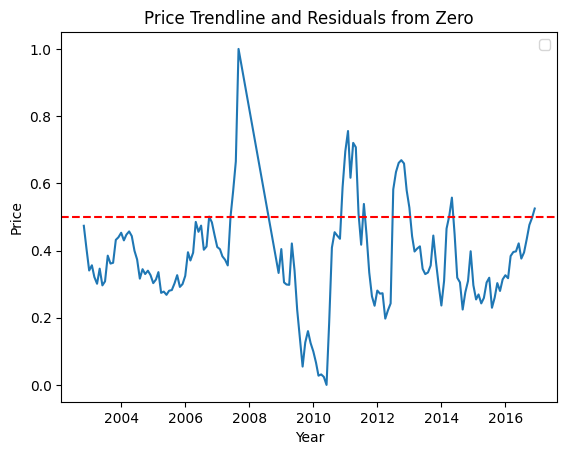

In [57]:
australia_wheat_model_data = pull_model_data('AUS', 'Wheat (ASW)_Australia (Eastern States).csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Australia.csv')

plt.plot(australia_wheat_model_data['Date'], australia_wheat_model_data['Wheat Futures'])
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price Trendline and Residuals from Zero')
plt.legend()
plt.show()

In [128]:
unique_iso = [] # Keep track of the unique iso codes for this project

**Pulling Corn Commodity Data Across All Countries**<br/>
<span style="color: yellow;">**There is no production/pricing data on corn provided by the FAO; however, there is __Maize__ data**</span><br/>

In [149]:
parent_directory = 'corn_model_data'
futures_file = 'CBOT_Corn_Futures.csv'
index_file = 'FAO_Cereal_Price_Index.csv'
related_international_prices = ['Maize (feed)_Brazil (Paranagua).csv', 'Maize (offer_Ukraine.csv', 'Maize (Up River)_Argentina.csv', 'Maize (US No. 2_United States of America (Gulf).csv']
related_production_data = ['Maize (corn)_Brazil.csv', 'Maize (corn)_Ukraine.csv', 'Maize (corn)_Argentina.csv', 'Maize (corn)_United States of America.csv']
related_iso_data = ['BRA', 'UKR', 'ARG', 'USA']

if not os.path.exists(f'model_data/{parent_directory}'):
    os.mkdir(f'model_data/{parent_directory}')

for i in range(len(related_international_prices)):
    model_data = pull_model_data(related_iso_data[i], related_international_prices[i], index_file, futures_file, related_production_data[i])
    model_data.to_csv(f'model_data/{parent_directory}/{related_production_data[i][:8]}_{related_iso_data[i]}_{parent_directory}.csv')

# Fill the unique iso table
for iso in related_iso_data:
    if iso not in unique_iso:
        unique_iso.append(iso)

Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (92, 9)
Shape Progress 2:  (92, 11)
Shape Progress 3:  (92, 12)
Shape Progress 4:  (92, 13)
Shape Progress 5:  (92, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (178, 9)
Shape Progress 2:  (178, 11)
Shape Progress 3:  (172, 12)
Shape Progress 4:  (172, 13)
Shape Progress 5:  (172, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)


**Pulling Rough Rice Commodity Data Across All Countries**<br/>

In [150]:
parent_directory = 'rice_model_data'
future_file = 'CBOT_Rough-Rice_Futures.csv'
index_file = 'FAO_Cereal_Price_Index.csv'
related_international_prices = [
    'Rice (5% broken_Uruguay.csv', 'Rice (5% broken)_Thailand (Bangkok).csv', 'Rice (5% broken)_Viet Nam.csv',
    'Rice (25% broken)_India.csv', 'Rice (25% broken)_Pakistan.csv', 'Rice (25% broken)_Thailand (Bangkok).csv',
    'Rice (25% broken)_Viet Nam.csv', 'Rice (Basmati Ordinary)_Pakistan.csv', 'Rice (Fragrant 100%)_Thailand (Bangkok).csv',
    'Rice (Glutinous 10%)_Thailand (Bangkok).csv', 'Rice (Parboiled 100%)_Thailand (Bangkok).csv', 'Rice (Thai 100% B)_Thailand (Bangkok).csv',
    'Rice (Thai A1 Super)_Thailand (Bangkok).csv', 'Rice (US California Medium Grain)_United States of America.csv',
    'Rice (US No. 2_United States of America.csv'
]
related_production_data = [
    'Rice_Uruguay.csv', 'Rice_Thailand.csv', 'Rice_Viet Nam.csv', 'Rice_India.csv', 'Rice_Pakistan.csv', 'Rice_Thailand.csv',
    'Rice_Viet Nam.csv', 'Rice_Pakistan.csv', 'Rice_Thailand.csv', 'Rice_Thailand.csv', 'Rice_Thailand.csv', 'Rice_Thailand.csv',
    'Rice_Thailand.csv', 'Rice_United States of America.csv', 'Rice_United States of America.csv'
]
related_iso_data = [
    'URY', 'THA', 'VNM', 'IND', 'PAK', 'THA', 'VNM', 'PAK', 'THA', 'THA', 'THA', 'THA', 'THA', 'USA', 'USA'
]

if not os.path.exists(f'model_data/{parent_directory}'):
    os.mkdir(f'model_data/{parent_directory}')

for i in range(len(related_international_prices)):
    model_data = pull_model_data(related_iso_data[i], related_international_prices[i], index_file, futures_file, related_production_data[i])
    model_data.to_csv(f'model_data/{parent_directory}/{related_production_data[i][:8]}_{related_iso_data[i]}_{parent_directory}.csv')

# Fill the unique iso table
for iso in related_iso_data:
    if iso not in unique_iso:
        unique_iso.append(iso)

Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (132, 9)
Shape Progress 2:  (132, 11)
Shape Progress 3:  (132, 12)
Shape Progress 4:  (132, 13)
Shape Progress 5:  (132, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (198, 9)
Shape Progress 2:  (198, 11)
Shape Progress 3:  (132, 12)
Shape Progress 4:  (132, 13)
Shape Progress 5:  (132, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape P

**Pulling Soybean Commodity Data Across All Countries**

In [151]:
parent_directory = 'soybean_model_data'
future_file = 'CBOT_Soybean_Futures.csv'
index_file = 'FAO_Cereal_Price_Index.csv'
related_international_prices = ['Soybean (US_United States of America (Gulf).csv', 'Soybean (US_United States of America.csv']
related_production_data = ['Soya beans_United States of America.csv', 'Soya beans_United States of America.csv']
related_iso_data = ['USA', 'USA']

if not os.path.exists(f'model_data/{parent_directory}'):
    os.mkdir(f'model_data/{parent_directory}')

for i in range(len(related_international_prices)):
    model_data = pull_model_data(related_iso_data[i], related_international_prices[i], index_file, futures_file, related_production_data[i])
    model_data.to_csv(f'model_data/{parent_directory}/{related_production_data[i][:8]}_{related_iso_data[i]}_{parent_directory}.csv')

# Fill the unique iso table
for iso in related_iso_data:
    if iso not in unique_iso:
        unique_iso.append(iso)

Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (275, 9)
Shape Progress 2:  (275, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (252, 9)
Shape Progress 2:  (252, 11)
Shape Progress 3:  (198, 12)
Shape Progress 4:  (198, 13)
Shape Progress 5:  (198, 14)


**Pulling Wheat Commodity Data Across All Countries**<br/>

In [132]:
parent_directory = 'wheat_model_data'

# Australia (saw international_prices/Wheat (ASW)_Australia (Eastern States).csv)
australia_wheat_model_data = pull_model_data('AUS', 'Wheat (ASW)_Australia (Eastern States).csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Australia.csv')
australia_wheat_model_data.to_csv(f'model_data/{parent_directory}/australia_wheat_model_data.csv')

# Argentina (saw international_prices/Wheat (12%_Argentina.csv)
argentina_wheat_model_data = pull_model_data('ARG', 'Wheat (12%_Argentina.csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Argentina.csv')
argentina_wheat_model_data.to_csv(f'model_data/{parent_directory}/argentina_wheat_model_data.csv')

# Canada (saw international_prices/Wheat (CWRS_Canada (St Lawrence).csv)
canada_wheat_model_data = pull_model_data('CAN', 'Wheat (CWRS_Canada (St Lawrence).csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Canada.csv')
canada_wheat_model_data.to_csv(f'model_data/{parent_directory}/canada_wheat_model_data.csv')

# Ukraine (saw international_prices/Wheat (milling_Ukraine.csv)
ukraine_wheat_model_data = pull_model_data('UKR', 'Wheat (milling_Ukraine.csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Ukraine.csv')
ukraine_wheat_model_data.to_csv(f'model_data/{parent_directory}/ukraine_wheat_model_data.csv')

# Russian Federation (saw international_prices/Wheat (offer_Russian Federation.csv)
russian_federation_model_data = pull_model_data('RUS', 'Wheat (offer_Russian Federation.csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_Russian Federation.csv')
russian_federation_model_data.to_csv(f'model_data/{parent_directory}/Russian_Federation_Model_Data.csv')

# United States (saw international_prices/Wheat (US No. 2_United States of America (Gulf).csv)
united_states_wheat_model_data = pull_model_data('USA', 'Wheat (US No. 2_United States of America (Gulf).csv', 'FAO_Cereal_Price_Index.csv', 'CBOT_Wheat_Futures.csv', 'Wheat_United States of America.csv')
united_states_wheat_model_data.to_csv(f'model_data/{parent_directory}/United_States_Wheat_Model_Data.csv')

related_iso_data = ['AUS', 'ARG', 'CAN', 'UKR', 'RUS', 'USA']

# Fill the unique iso table
for iso in related_iso_data:
    if iso not in unique_iso:
        unique_iso.append(iso)

Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (185, 9)
Shape Progress 2:  (185, 11)
Shape Progress 3:  (156, 12)
Shape Progress 4:  (156, 13)
Shape Progress 5:  (156, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (202, 9)
Shape Progress 2:  (202, 11)
Shape Progress 3:  (168, 12)
Shape Progress 4:  (168, 13)
Shape Progress 5:  (168, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (190, 9)
Shape Progress 2:  (190, 11)
Shape Progress 3:  (157, 12)
Shape Progress 4:  (157, 13)
Shape Progress 5:  (157, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (178, 9)
Shape Progress 2:  (178, 11)
Shape Progress 3:  (144, 12)
Shape Progress 4:  (144, 13)
Shape Progress 5:  (144, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (110, 9)
Shape Progress 2:  (110, 11)
Shape Progress 3:  (110, 12)
Shape Progress 4:  (110, 13)
Shape Progress 5:  (110, 14)
Commody Price Data Shape:  (407, 7)
Shape Progress 1:  (204, 9)
Shape Progress 2:  (204, 11)
Shape P

In [133]:
unique_iso

['BRA',
 'UKR',
 'ARG',
 'USA',
 'URY',
 'THA',
 'VNM',
 'IND',
 'PAK',
 'AUS',
 'CAN',
 'RUS']

## Part 2: Statistical Analysis
Statistical Analysis is an important part of data science and machine learning in order to determine which features are important to the model and which features can be removed. This section will analyze the data collected in `Part 1: Data Collection` and determine which features are important to the model and which features can be removed. For each statistical test, an alpha value ($\alpha$) of `0.01` will be used. The null hypothesis ($H_0$) will be that the two variables are not correlated, and the alternative hypothesis ($H_1$) will be that the two variables are correlated. If the p-value is less than the alpha value, then the null hypothesis will be rejected and the alternative hypothesis will be accepted. 

To summarize the analysis that will be performed, here is a breakdown of each section:
* **Part 2.1: PROTEUS Index Analysis:** This section will analyze how the PROTEUS index has changed over time and determine if it is a good indicator for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.2: Food Indices Analysis:** This section will analyze how the food indices have changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.3: Current Food Commodity Prices Analysis:** This section will analyze how the current food commodity prices have changed over time and determine if they are good indicators for fluctuating international food prices from other regions and food industries. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.4: Futures Trend Analysis:** This section will analyze how the futures trend data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.5: Harvest Data Analysis:** This section will analyze how the harvest data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.
* **Part 2.6: Articles & Article Sentiment Analysis:** This section will analyze how the articles and article sentiment has changed over time and determine if they are good indicators for fluctuating international food prices. _______________________

As a reminder, all data has already been cleaned in `Part 1: Data Collection`, including the normalization of the data. Since this research is focused on anomaly detection for the purpose of warning countries of potential food insecurity, data outliers will not be removed.

In [152]:
ALPHA_VALUE = 0.01

### Part 2.1: PROTEUS Index Analysis
This section will analyze how the PROTEUS index has changed over time and determine if it is a good indicator for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

**Conclusion:** 


In [ ]:
# Given a food commodity in the directory 'cleaned_data/international_prices', determine the region and match the associated PROTEUS value


In [ ]:
# (FROM THE NOTEBOOK I MADE WITH SYDNEY)

# Determine the statistical relationship between the food index and each of the other indices using Spearman's Correlation Coefficient
food_v_cereal = spearmanr(data_food_price_index['Food Price Index'], data_cereal_price_index['Cereals Price Index'])
food_v_meat = spearmanr(data_food_price_index['Food Price Index'], data_meat_price_index['Meat Price Index'])
food_v_dairy = spearmanr(data_food_price_index['Food Price Index'], data_dairy_price_index['Dairy Price Index'])
food_v_oil = spearmanr(data_food_price_index['Food Price Index'], data_oil_price_index['Oils Price Index'])
food_v_sugar = spearmanr(data_food_price_index['Food Price Index'], data_sugar_price_index['Sugar Price Index'])

print('The Relationship between the food index and the cereal index is significant:', food_v_cereal[1] < ALPHA_VALUE, "(p-value:", food_v_cereal[1], ")")
print('The Relationship between the food index and the meat index is significant:', food_v_meat[1] < ALPHA_VALUE, "(p-value:", food_v_meat[1], ")")
print('The Relationship between the food index and the dairy index is significant:', food_v_dairy[1] < ALPHA_VALUE, "(p-value:", food_v_dairy[1], ")")
print('The Relationship between the food index and the oil index is significant:', food_v_oil[1] < ALPHA_VALUE, "(p-value:", food_v_oil[1], ")")
print('The Relationship between the food index and the sugar index is significant:', food_v_sugar[1] < ALPHA_VALUE, "(p-value:", food_v_sugar[1], ")")


### Part 2.2: Food Indices Analysis
In this section we'll be looking at the relationship between each price index and the other prices indices, recognizing how closely the price indices match each other as the economy changes throughout the years. Normalized, non-normal, numerical data will be used, meaning the statistical test that will be used will be the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). This statistical test uses a monotonic function and performs well even with non-normal data.

**Conclusion:** Based on the results achieved in the last cell of this section (`Part 3.1`), each of the indices are correlating, meaning they all have statistically significant similarity between each other. Understanding this, each index is a good signal for the overall food index, meaning the food index could be used as a signal in the machine learning model, including information about the other indices.

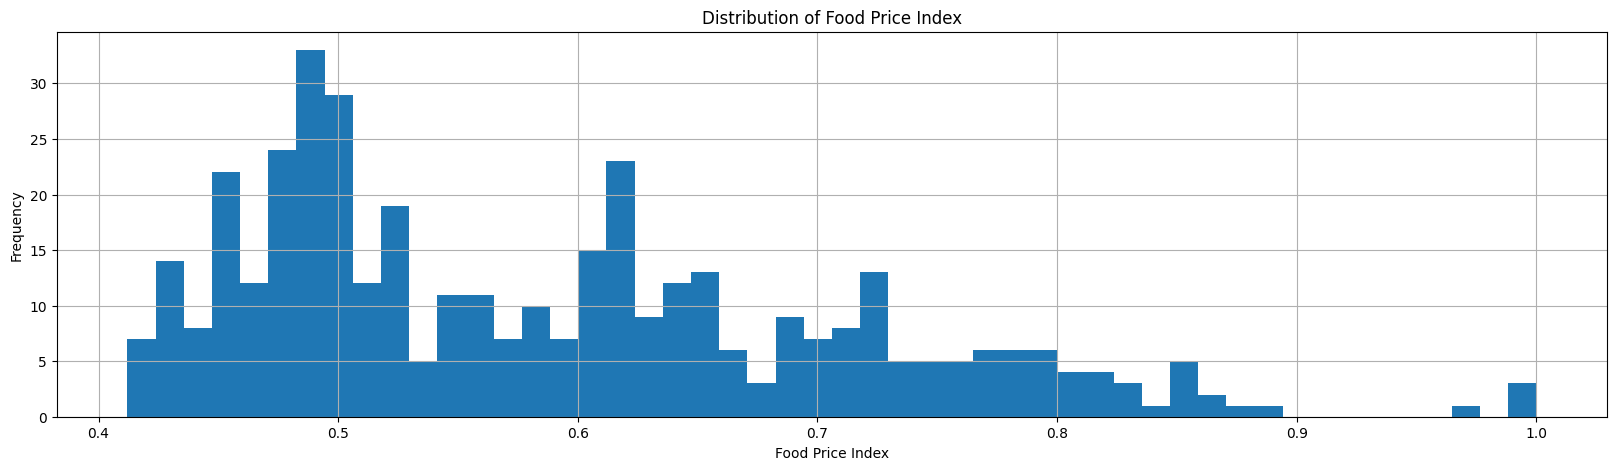

In [147]:
# Determine if the data is normally distributed (histogram of index values, binned by value)
data_food_price_index['Food Price Index'].hist(bins=50)
plt.xlabel('Food Price Index')
plt.ylabel('Frequency')
plt.title('Distribution of Food Price Index')
plt.show()

# Based on the histogram below, the data is not normally distributed; it does not follow a bell curve and there are multiple peaks within the distribution.

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\4068553017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21436\4068553017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index']

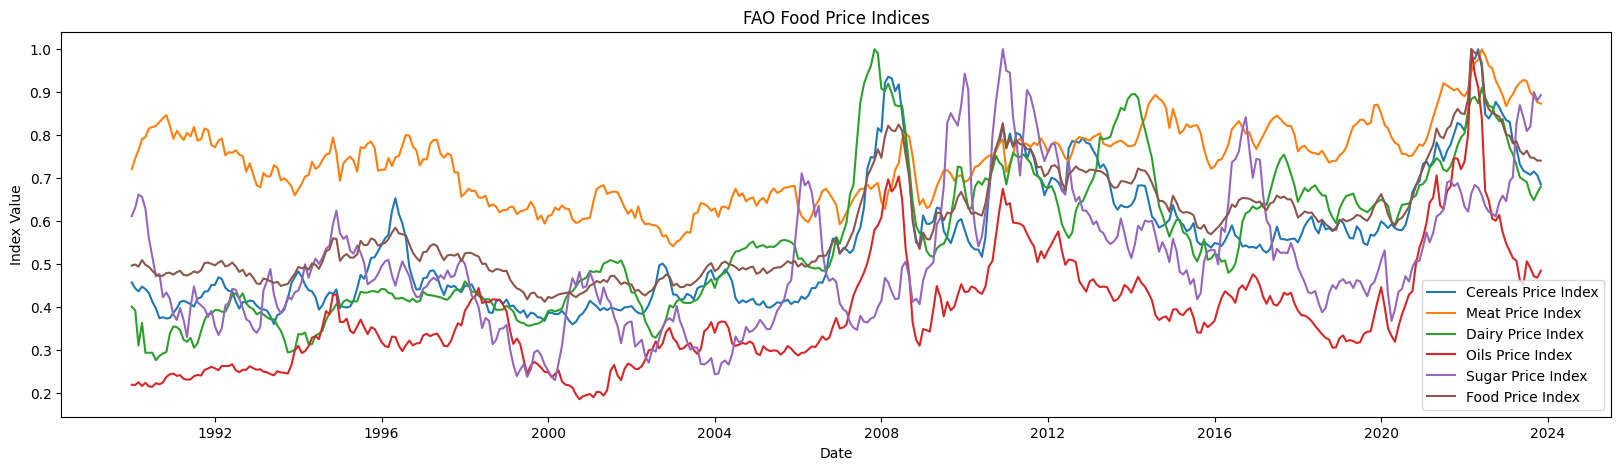

In [148]:
# Normalize the different indices by dividing each index value by the max value of that index
data_food_price_index['Food Price Index'] = data_food_price_index['Food Price Index'] / data_food_price_index['Food Price Index'].max()
data_cereal_price_index['Cereals Price Index'] = data_cereal_price_index['Cereals Price Index'] / data_cereal_price_index['Cereals Price Index'].max()
data_meat_price_index['Meat Price Index'] = data_meat_price_index['Meat Price Index'] / data_meat_price_index['Meat Price Index'].max()
data_dairy_price_index['Dairy Price Index'] = data_dairy_price_index['Dairy Price Index'] / data_dairy_price_index['Dairy Price Index'].max()
data_oil_price_index['Oils Price Index'] = data_oil_price_index['Oils Price Index'] / data_oil_price_index['Oils Price Index'].max()
data_sugar_price_index['Sugar Price Index'] = data_sugar_price_index['Sugar Price Index'] / data_sugar_price_index['Sugar Price Index'].max()

# Plot the normalized indices
plt.plot(data_cereal_price_index['Month'], data_cereal_price_index['Cereals Price Index'], label='Cereals Price Index')
plt.plot(data_meat_price_index['Month'], data_meat_price_index['Meat Price Index'], label='Meat Price Index')
plt.plot(data_dairy_price_index['Month'], data_dairy_price_index['Dairy Price Index'], label='Dairy Price Index')
plt.plot(data_oil_price_index['Month'], data_oil_price_index['Oils Price Index'], label='Oils Price Index')
plt.plot(data_sugar_price_index['Month'], data_sugar_price_index['Sugar Price Index'], label='Sugar Price Index')
plt.plot(data_food_price_index['Month'], data_food_price_index['Food Price Index'], label='Food Price Index')

plt.rcParams["figure.figsize"] = (20,5)
plt.title('FAO Food Price Indices')
plt.ylabel('Index Value')
plt.xlabel('Date')
plt.legend()
plt.show()

In [153]:
# Determine the statistical relationship between the food index and each of the other indices using Spearman's Correlation Coefficient
food_v_cereal = spearmanr(data_food_price_index['Food Price Index'], data_cereal_price_index['Cereals Price Index'])
food_v_meat = spearmanr(data_food_price_index['Food Price Index'], data_meat_price_index['Meat Price Index'])
food_v_dairy = spearmanr(data_food_price_index['Food Price Index'], data_dairy_price_index['Dairy Price Index'])
food_v_oil = spearmanr(data_food_price_index['Food Price Index'], data_oil_price_index['Oils Price Index'])
food_v_sugar = spearmanr(data_food_price_index['Food Price Index'], data_sugar_price_index['Sugar Price Index'])

print('The Relationship between the food index and the cereal index is significant:', food_v_cereal[1] < ALPHA_VALUE, "(p-value:", food_v_cereal[1], ")")
print('The Relationship between the food index and the meat index is significant:', food_v_meat[1] < ALPHA_VALUE, "(p-value:", food_v_meat[1], ")")
print('The Relationship between the food index and the dairy index is significant:', food_v_dairy[1] < ALPHA_VALUE, "(p-value:", food_v_dairy[1], ")")
print('The Relationship between the food index and the oil index is significant:', food_v_oil[1] < ALPHA_VALUE, "(p-value:", food_v_oil[1], ")")
print('The Relationship between the food index and the sugar index is significant:', food_v_sugar[1] < ALPHA_VALUE, "(p-value:", food_v_sugar[1], ")")


The Relationship between the food index and the cereal index is significant: True (p-value: 9.190948302921824e-199 )
The Relationship between the food index and the meat index is significant: True (p-value: 3.9477953955645325e-57 )
The Relationship between the food index and the dairy index is significant: True (p-value: 4.717837641128829e-124 )
The Relationship between the food index and the oil index is significant: True (p-value: 3.7248966939357894e-150 )
The Relationship between the food index and the sugar index is significant: True (p-value: 5.6964546002095005e-70 )


### Part 2.3: Current Food Commodity Prices Analysis
Given a specific food commodity, are the prices of that commodity in different regions of the world correlated? To help understand this relationship between normalized, non-normal-distributed, numerical datapoints, a statistical test can be used to determine the correlation. Based on this data description, the best statistical test to use would be the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). This statistical test uses a monotonic function and performs well even with non-normal data.

**Conclusion:** The relationship between food commodities is statistically significant, even between different regions and commodities which are from entirely different markets/food industries. This relationship could point to the possibility of creating a general model for food commodity pricing prediction rather than having to fine-tune a model for each specific country, market, or commodity. This would be a huge benefit to the research, as it would allow for a more generalized model to be used in the future for easy updating and usage by other parties.

In [154]:
commodity_item_trends.keys()

dict_keys(['Maize (Up River)', 'Wheat (12%', 'Meat: Bovine (Cow 90CL to US', 'Meat: Ovine (Medium trade lamb 18-20 Kg)', 'Barley (feed)', 'Wheat (ASW)', 'Jute BWD (f.o.b. Mongla', 'Maize (feed)', 'Urea (N fertilizer)', 'Wheat (feed)', 'Wheat (milling', 'Meat: Bovine (Fresh', 'Meat: Pig meat (Meat of swine', 'Meat: Poultry (Meat and edible offal. Fresh', 'Sisal (Brazil Bahia', 'Wheat (CWRS', 'Potassium chloride', 'Bananas (US East Coast - Main Brands Central America', 'Bananas (US East Coast - Other Brands Central America', 'Bananas (US West Coast - Main Brands Central America', 'Bananas (US West Coast - Other Brands Central America', 'Sisal (East African', 'Dairy: Butter (European & Oceania average indicative export prices', 'Dairy: Cheddar Cheese (European & Oceania average indicative export prices', 'Dairy: Skim Milk Powder (European & Oceania average indicative export prices', 'Dairy: Whole Milk Powder (European & Oceania average indicative export prices', 'Wheat (grade 1', 'Meat: P

In [155]:
# Pull certain data to use for these statistical tests
grains = commodity_item_trends['Barley (feed)']
meats = commodity_item_trends['Meat: Bovine (Fresh']

# dairy
skim_milk_powder = commodity_item_trends['Dairy: Skim Milk Powder (European & Oceania average indicative export prices']
whole_milk_powder = commodity_item_trends['Dairy: Whole Milk Powder (European & Oceania average indicative export prices']

# oils
palm_oil = commodity_item_trends['Palm oil (Crude']
coconut_oil = commodity_item_trends['Coconut oil (Philippines']

# An analysis cannot be done on sugar because it is only for US

In [156]:
# Merge the two grains dataframes and only keep the rows where both prices are not nan
grains_merged = pd.merge(grains['European Union (France)'], grains['Australia (Eastern States)'], on='Date', how='inner')
grains_merged = grains_merged[grains_merged['Price_x'].notna() & grains_merged['Price_y'].notna()]

# Merge the two meats dataframes and only keep the rows where both prices are not nan
meats_merged = pd.merge(meats['Brazil'], meats['United States of America'], on='Date', how='inner')
meats_merged = meats_merged[meats_merged['Price_x'].notna() & meats_merged['Price_y'].notna()]

# Merge the two skim milk powder dataframes and only keep the rows where both prices are not nan
milk_powder_merged = pd.merge(skim_milk_powder['Europe and Oceania'], whole_milk_powder['Europe and Oceania'], on='Date', how='inner')
milk_powder_merged = milk_powder_merged[milk_powder_merged['Price_x'].notna() & milk_powder_merged['Price_y'].notna()]

# Merge the two oils dataframes and only keep the rows where both prices are not nan
oils_merged = pd.merge(palm_oil['Unspecified'], coconut_oil['Philippines'], on='Date', how='inner')
oils_merged = oils_merged[oils_merged['Price_x'].notna() & oils_merged['Price_y'].notna()]

In [157]:
# Determine if 'Australia (Eastern States)' and 'European Union (France)' have a statistically significant relationship for their grain prices
grains_stats = spearmanr(grains_merged['Price_x'], grains_merged['Price_y'])
print("The relationship between Australia (Eastern States) and European Union (France) for grain prices is significant:", grains_stats[1] < ALPHA_VALUE, "(p-value:", grains_stats[1], ")")

# Determine if 'Brazil' and 'United States of America' have a statistically significant relationship for their meat prices
meats_stats = spearmanr(meats_merged['Price_x'], meats_merged['Price_y'])
print("The relationship between Brazil and United States of America for meat prices is significant:", meats_stats[1] < ALPHA_VALUE, "(p-value:", meats_stats[1], ")")

# Determine if 'Europe and Oceania' and 'Europe and Oceania' have a statistically significant relationship for their skim milk powder prices
milk_powder_stats = spearmanr(milk_powder_merged['Price_x'], milk_powder_merged['Price_y'])
print("The relationship between Europe and Oceania for skim milk powder prices is significant:", milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", milk_powder_stats[1], ")")

# Determine if 'Unspecified' and 'Philippines' have a statistically significant relationship for their oil prices
oils_stats = spearmanr(oils_merged['Price_x'], oils_merged['Price_y'])
print("The relationship between Unspecified and Philippines for oil prices is significant:", oils_stats[1] < ALPHA_VALUE, "(p-value:", oils_stats[1], ")")

The relationship between Australia (Eastern States) and European Union (France) for grain prices is significant: True (p-value: 1.693379903696403e-111 )
The relationship between Brazil and United States of America for meat prices is significant: True (p-value: 1.9080097376972336e-60 )
The relationship between Europe and Oceania for skim milk powder prices is significant: True (p-value: 1.5727421560024846e-201 )
The relationship between Unspecified and Philippines for oil prices is significant: True (p-value: 1.5173400662901552e-98 )


In [158]:
# Determine if commodity prices across food types have statistically significant relationships
grains_meats_merged = pd.merge(grains_merged, meats_merged, on='Date', how='inner')
grains_meats_stats = spearmanr(grains_meats_merged['Price_x_x'], grains_meats_merged['Price_x_y'])
print("The relationship between grains and meats prices is significant:", grains_meats_stats[1] < ALPHA_VALUE, "(p-value:", grains_meats_stats[1], ")")

grains_milk_powder_merged = pd.merge(grains_merged, milk_powder_merged, on='Date', how='inner')
grains_milk_powder_stats = spearmanr(grains_milk_powder_merged['Price_x_x'], grains_milk_powder_merged['Price_x_y'])
print("The relationship between grains and milk powder prices is significant:", grains_milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", grains_milk_powder_stats[1], ")")

grains_oils_merged = pd.merge(grains_merged, oils_merged, on='Date', how='inner')
grains_oils_stats = spearmanr(grains_oils_merged['Price_x_x'], grains_oils_merged['Price_x_y'])
print("The relationship between grains and oils prices is significant:", grains_oils_stats[1] < ALPHA_VALUE, "(p-value:", grains_oils_stats[1], ")")

meats_milk_powder_merged = pd.merge(meats_merged, milk_powder_merged, on='Date', how='inner')
meats_milk_powder_stats = spearmanr(meats_milk_powder_merged['Price_x_x'], meats_milk_powder_merged['Price_x_y'])
print("The relationship between meats and milk powder prices is significant:", meats_milk_powder_stats[1] < ALPHA_VALUE, "(p-value:", meats_milk_powder_stats[1], ")")

meats_oils_merged = pd.merge(meats_merged, oils_merged, on='Date', how='inner')
meats_oils_stats = spearmanr(meats_oils_merged['Price_x_x'], meats_oils_merged['Price_x_y'])
print("The relationship between meats and oils prices is significant:", meats_oils_stats[1] < ALPHA_VALUE, "(p-value:", meats_oils_stats[1], ")")

milk_powder_oils_merged = pd.merge(milk_powder_merged, oils_merged, on='Date', how='inner')
milk_powder_oils_stats = spearmanr(milk_powder_oils_merged['Price_x_x'], milk_powder_oils_merged['Price_x_y'])
print("The relationship between milk powder and oils prices is significant:", milk_powder_oils_stats[1] < ALPHA_VALUE, "(p-value:", milk_powder_oils_stats[1], ")")

The relationship between grains and meats prices is significant: True (p-value: 2.245828871245746e-44 )
The relationship between grains and milk powder prices is significant: True (p-value: 1.3617980366354796e-43 )
The relationship between grains and oils prices is significant: True (p-value: 7.805759298169778e-67 )
The relationship between meats and milk powder prices is significant: True (p-value: 1.710528454257644e-33 )
The relationship between meats and oils prices is significant: True (p-value: 2.758125734137385e-75 )
The relationship between milk powder and oils prices is significant: True (p-value: 3.4631881108618005e-57 )


### Part 2.4: Futures Trend Analysis
This section will analyze how the futures trend data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

### Part 2.5: Harvest Data Analysis
This section will analyze how the harvest data has changed over time and determine if they are good indicators for fluctuating international food prices. For this section, the [Spearman's Rank Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) will be used.

### Part 2.6: Articles & Article Sentiment Analysis
This section will analyze how the articles and article sentiment has changed over time and determine if they are good indicators for fluctuating international food prices. _______________________

## Part 3: Getting Data Ready For Warning Model

In [23]:
warnings = pd.read_csv('all_data/15-16_warnings_data.csv')
warnings

,country,commodity,warning_level (1=moderate; 2=high),month,year,growth_rate_3,growth_rate_12
0,Argentina,Wheat Flour,2,12,2023,9.8,5.1
1,Myanmar,Rice,2,1,2024,9.8,4.2
2,Nigeria,Staple Foods,2,9,2023,na,na
3,Pakistan,Wheat Flour,2,1,2024,na,na
4,South Sudan,Staple Foods,2,1,2024,7.1,3.1
...,...,...,...,...,...,...,...
1000,Nicaragua,Maize,1,11,2015,-8.7,3
1001,South Africa,Maize,2,11,2015,4.6,3.3
1002,Uganda,Maize,2,11,2015,12.9,6
1003,United Republic of Tanzania,Maize,2,11,2015,1.6,7.5


### Part 3.1: Clean the Dataset

In [24]:
# Turn all row entries with values 'na', 'n/a', and variations of that into actual NaN values
warnings = warnings.replace('na', np.nan)
warnings = warnings.replace('n/a', np.nan)
warnings = warnings.replace('N/A', np.nan)
warnings = warnings.replace('N/a', np.nan)

In [25]:
# Strip all whitespace surrounding 'country' and 'commodity' values
warnings['country'] = warnings['country'].str.strip()
warnings['commodity'] = warnings['commodity'].str.strip()

# Make them titles as well
warnings['country'] = warnings['country'].str.title()
warnings['commodity'] = warnings['commodity'].str.title()

In [26]:
# If a country is under warning for staple foods, does that mean it's under warning for other types of food too?
staple_foods = warnings[warnings['commodity'] == 'Staple Foods']
staple_foods_countries = staple_foods['country'].unique()
staple_foods_countries

array(['Nigeria', 'South Sudan', 'Sudan', 'Haiti', 'Zimbabwe'],
      dtype=object)

In [27]:
warnings.rename(columns={'warning_level (1=moderate; 2=high)':'warning_level'}, inplace=True)

In [28]:
# Given the 'month' and 'year' column, mix them together to create a 'Date' column which is a Datetime dtype
# For each month, it should simply be the first day, no need to track down to time
warnings['Date'] = pd.to_datetime(warnings['month'].astype(str) + '-' + warnings['year'].astype(str))

# Drop the 'month' and 'year' columns
warnings.drop(columns=['month', 'year'], inplace=True)

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\1784572108.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  warnings['Date'] = pd.to_datetime(warnings['month'].astype(str) + '-' + warnings['year'].astype(str))


### Part 3.2: Given the Commodity Names, Map To Known Commodities
The current list of commodities includes items like "Staple Foods" and "Food Items". Theses commodities can be mapped to the actual commodities we're testing with which are `corn`, `rice`, `soybeans`, and `wheat`. Also, if there is commodity data which does not correlate to the current testing data, it should simply be removed. Below is a data description of the commodities in the warning dataset and what they should map to (in order of value counts):
* **Maize:** corn
* **Staple Foods:** corn, rice, soybeans, wheat
* **Coarse Grains:** remove
* **Wheat Flour:** wheat
* **Rice:** rice
* **Food Items:** remove (processed food)
* **Cereals:** remove (corn, rice, wheat)
* **Grains:** remove (corn, rice, wheat)
* **Wheat:** wheat
* **Maize Meal:** corn
* **Sorghum:** remove
* **Bread:** remove
* **Red Beans:** remove
* **Rice & Wheat Flour:** rice, wheat
* **Toritillas:** remove
* **Beans:** remove
* **Black Beans:** remove


In [29]:
warnings

,country,commodity,warning_level,growth_rate_3,growth_rate_12,Date
0,Argentina,Wheat Flour,2,9.8,5.1,2023-12-01
1,Myanmar,Rice,2,9.8,4.2,2024-01-01
2,Nigeria,Staple Foods,2,NaN,NaN,2023-09-01
3,Pakistan,Wheat Flour,2,NaN,NaN,2024-01-01
4,South Sudan,Staple Foods,2,7.1,3.1,2024-01-01
...,...,...,...,...,...,...
1000,Nicaragua,Maize,1,-8.7,3,2015-11-01
1001,South Africa,Maize,2,4.6,3.3,2015-11-01
1002,Uganda,Maize,2,12.9,6,2015-11-01
1003,United Republic Of Tanzania,Maize,2,1.6,7.5,2015-11-01


In [30]:
# Implement a function which does what's outlined in the above markdown cell
def map_commodities_to_known_data(warnings):
    """
    Given a commodity, determine if it should be removed or mapped to a different commodity name.
    To see the full listing, read the `Part 3.2` section of the notebook. Some commodities, like
    "Staple Foods" will map to multiple commodities. If this is the case, simply make multiple rows
    for each new commodity (Staple Foods -> corn row, rice row, soybeans row, wheat row)
    :param pd.DataFrame warnings: Dataframe to map the commodities to known data
    :return: The dataframe with the mapped commodities
    """
    # Remove rows which cannot be mapped to the known data for training
    commodities_to_remove = [
        'Coarse Grains', 'Food Items', 'Sorghum', 'Bread', 'Red Beans', 'Tortillas (Maize)',
        'Beans', 'Black Beans', 'Cereals', 'Grains', 'Potatoes'
    ]
    warnings = warnings[~warnings['commodity'].isin(commodities_to_remove)]

    # Map the commodities to known data
    mappings = {
        'Maize':['corn'], 'Staple Foods':['corn', 'rice', 'soybeans', 'wheat'], 'Wheat Flour':['wheat'],
        'Rice':['rice'], 'Wheat':['wheat'], 'Maize Meal':['corn'], 'Rice & Wheat Flour':['rice', 'wheat'],
        'White Maize':['corn']
    }
    new_rows = []
    for i,row in warnings.iterrows():
        if row['commodity'] in mappings:
            for commodity in mappings[row['commodity']]:
                new_rows.append([
                    row['country'], commodity, row['warning_level'], 
                    row['growth_rate_3'], row['growth_rate_12'], row['Date']
                ])

    # Remove the old rows
    warnings = warnings[~warnings['commodity'].isin(mappings.keys())]

    # Add the new rows (use pd.concat)
    warnings = pd.concat([warnings, pd.DataFrame(new_rows, columns=warnings.columns)], axis=0)

    return warnings

warnings = map_commodities_to_known_data(warnings)
warnings

,country,commodity,warning_level,growth_rate_3,growth_rate_12,Date
0,Argentina,wheat,2,9.8,5.1,2023-12-01
1,Myanmar,rice,2,9.8,4.2,2024-01-01
2,Nigeria,corn,2,NaN,NaN,2023-09-01
3,Nigeria,rice,2,NaN,NaN,2023-09-01
4,Nigeria,soybeans,2,NaN,NaN,2023-09-01
...,...,...,...,...,...,...
1244,Nicaragua,corn,1,-8.7,3,2015-11-01
1245,South Africa,corn,2,4.6,3.3,2015-11-01
1246,Uganda,corn,2,12.9,6,2015-11-01
1247,United Republic Of Tanzania,corn,2,1.6,7.5,2015-11-01


### Part 3.3: Given Country Names, Only Keep Known Countries
There are only a few countries which were reserved for use in training. Therefore, any country which is not compatible with the data required to get an accurate prediction will be removed. In the future, all countries will be able to be processed, but only a select few were chosen for the purpose of scope for this research project. Below is a data description of the countries which we know and belong to specific commodities:
* **Corn:** Argentina, Brazil, Ukraine, USA
* **Rice:** Indonesia, Pakistan, Thailand, USA, Uruguay, Viet Nam
* **Soybeans:** USA
* **Wheat:** Argentina, Australia, Canada, Russian Federation, Ukraine, USA

In [31]:
def keep_certain_countries(warnings):
    """
    Given the warnings dataframe, only keep the countries which are in the model_data list
    :param pd.DataFrame warnings: The dataframe containing the warnings
    :return: The dataframe containing the warnings for only the unique_iso countries
    """
    model_data = {
        'corn':['Argentina', 'Brazil', 'Ukraine', 'United States of America'],
        'rice':['Indonesia', 'Pakistan', 'Thailand', 'United State of America', 'Uruguay', 'Viet Nam'],
        'soybeans':['United States of America'],
        'wheat':['Argentina', 'Australia', 'Canada', 'Russian Federation', 'Ukraine', 'United States of America']
    }

    # Only keep the rows which both meet the commodity (model_data key) and country (model_data value) criteria
    new_rows = []
    for i,row in warnings.iterrows():
        if row['country'] in model_data[row['commodity']]:
            new_rows.append(row)
    warnings = pd.DataFrame(new_rows, columns=warnings.columns)

    return warnings

warnings = keep_certain_countries(warnings)
warnings.reset_index(drop=True, inplace=True)
warnings.sort_values(by=['country', 'commodity'], inplace=True) # Order by country and commodity

warnings

,country,commodity,warning_level,growth_rate_3,growth_rate_12,Date
13,Argentina,corn,1,-0.1,-0.2,2017-01-01
14,Argentina,corn,2,19.2,4.8,2016-01-01
17,Argentina,corn,2,19.9,6.1,2016-02-01
19,Argentina,corn,2,9.1,6,2016-03-01
21,Argentina,corn,2,3.2,7,2016-05-01
23,Argentina,corn,2,5.3,8,2016-06-01
25,Argentina,corn,2,2.7,8.1,2016-07-01
27,Argentina,corn,2,-4.1,6.7,2016-08-01
29,Argentina,corn,2,-4.8,5,2016-09-01
31,Argentina,corn,2,-3.5,3.7,2016-10-01


In [32]:
# If there is a 1-month gap between warnings for a specific country/commodity pair, add another row saying there is a warning for the month in between
# Don't add rows if there is more than a 1-month gap
def fill_in_missing_months(warnings):
    """
    Given the warnings dataframe, fill in the missing months for each country/commodity pair
    :param pd.DataFrame warnings: The dataframe containing the warnings
    :return: The dataframe containing the warnings with the missing months filled in
    """
    new_rows = []
    for i in range(warnings.shape[0] - 1):
        current_row = warnings.iloc[i]
        next_row = warnings.iloc[i+1]

        # If the next row is a month ahead of the current row, add a new row for the month in between
        if (next_row['Date'] - current_row['Date']).days > 30:
            new_rows.append([
                current_row['country'], current_row['commodity'], current_row['warning_level'], 
                current_row['growth_rate_3'], current_row['growth_rate_12'], current_row['Date'] + pd.DateOffset(months=1)
            ])

    # Add the new rows
    warnings = pd.concat([warnings, pd.DataFrame(new_rows, columns=warnings.columns)], axis=0)
    warnings.sort_values(by=['country', 'commodity'], inplace=True) # Order by country and commodity
    warnings.reset_index(drop=True, inplace=True)

    return warnings

warnings = fill_in_missing_months(warnings)
warnings[['country', 'commodity']].value_counts()

country             commodity
Argentina           corn         18
Indonesia           rice         16
Brazil              corn         14
Argentina           wheat        10
Ukraine             wheat         8
Russian Federation  wheat         5
Thailand            rice          4
Viet Nam            rice          4
Name: count, dtype: int64

### Part 3.4: Bringing the Price Trend and Warning Data Together

In [54]:
def format_warnings_with_trend(country, commodity, file_path, plot = False):
    warnings_subset = warnings[(warnings['country'] == country) & (warnings['commodity'] == commodity)]
    price_trend = pd.read_csv(file_path)

    # Make sure 'Date' of both warnings and price_trend are datetime
    warnings_subset['Date'] = pd.to_datetime(warnings_subset['Date'])
    price_trend['Date'] = pd.to_datetime(price_trend['Date'])

    # Remove any rows from warnings where there is no price data for that date
    warnings_subset = warnings_subset[warnings_subset['Date'].isin(price_trend['Date'])]

    # Create a new price_trend dataframe which contains if there is an active warning or not as one of the columns
    final_output = price_trend.copy()
    final_output['Warning'] = 0

    for i,row in final_output.iterrows():
        if row['Date'] in warnings_subset['Date'].unique():
            final_output.at[i, 'Warning'] = warnings_subset[warnings_subset['Date'] == row['Date']]['warning_level'].values[0]

    if 'Unnamed: 0' in final_output.columns:
        final_output.drop(columns = ['Unnamed: 0'], inplace=True)

    # Cut off the trend data (only include anything after start of 2015 minus value of N_TREND_SAMPLES)
    final_output = final_output[final_output['Date'] >= '2014-09-01']

    if plot:
        # Minimize the size
        plt.figure(figsize=(5,8))

        # Plot the price trend
        plt.plot(final_output['Date'], final_output['Price'], label='Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Price Trend for {country.title()} and {commodity.title()}')

        # Ensure data values are sideways
        plt.xticks(rotation=45)

        # Get the rows from price_trend that there is a warning for
        warnings_dates = warnings_subset['Date'].unique()
        warnings_dates_high = []
        warnings_dates_moderate = []
        warnings_prices_high = []
        warnings_prices_moderate = []
        for date in warnings_dates:
            if warnings_subset[warnings_subset['Date'] == date]['warning_level'].values[0] == 1:
                warnings_prices_moderate.append(final_output[final_output['Date'] == date]['Price'])
                warnings_dates_moderate.append(date)
            else:
                warnings_prices_high.append(final_output[final_output['Date'] == date]['Price'])
                warnings_dates_high.append(date)

        

        # Plot the warnings
        plt.scatter(warnings_dates_high, warnings_prices_high, color='red', label='High Warning')
        plt.scatter(warnings_dates_moderate, warnings_prices_moderate, color='orange', label='Moderate Warning')

        # Show the mid-line (when there is no change in price)
        plt.axhline(.5, color='red', linestyle='--', label='No Price Fluctuation Change')

        plt.legend()
        plt.show()
        
    return final_output

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_21456\3503850650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warnings_subset['Date'] = pd.to_datetime(warnings_subset['Date'])


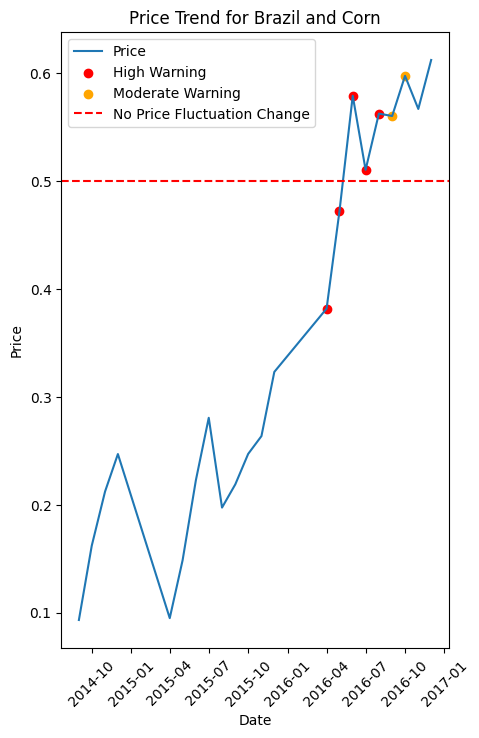

,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,Warning
0,2016-12-01,0.612518,0.526955,0.650018,0.601818,0.658735,0.799401,1.0,0
1,2016-11-01,0.567103,0.510442,0.649715,0.566170,0.616250,0.680875,1.0,0
2,2016-10-01,0.597795,0.494944,0.638557,0.546746,0.591088,0.564585,1.0,1
3,2016-09-01,0.560559,0.481415,0.626124,0.508510,0.512392,0.457926,1.0,1
4,2016-08-01,0.562794,0.468909,0.594265,0.530089,0.460829,0.353673,1.0,2
5,2016-07-01,0.510604,0.457855,0.526293,0.520540,0.504117,0.255363,1.0,2
6,2016-06-01,0.579298,0.448496,0.532139,0.558151,0.580258,0.165774,1.0,2
7,2016-05-01,0.472155,0.440162,0.445591,0.478184,0.539616,0.078820,1.0,2
8,2016-04-01,0.381925,0.433348,0.400627,0.408168,0.480028,0.000000,1.0,2
9,2015-12-01,0.323199,0.407412,0.225594,0.273564,0.361721,1.000000,-1.0,0


In [55]:
COUNTRY = 'Brazil'
COMMODITY = 'corn'
FILE_PATH = 'model_data\\corn_model_data\\Maize (c_BRA_corn_model_data.csv'
final_output = format_warnings_with_trend(COUNTRY, COMMODITY, FILE_PATH, True)
final_output

### Part 3.5: Getting All The Data Formatted For Input/Output

In [15]:
DATA_TO_LOAD = [
    ('Argentina', 'corn', 'model_data\corn_model_data\Maize (c_ARG_corn_model_data.csv'),
    ('Brazil', 'corn', 'model_data\corn_model_data\Maize (c_BRA_corn_model_data.csv'),
    ('Ukraine', 'corn', 'model_data\corn_model_data\Maize (c_UKR_corn_model_data.csv'),
    ('United States of America', 'corn', 'model_data\corn_model_data\Maize (c_USA_corn_model_data.csv'),
    ('Indonesia', 'rice', 'model_data\\rice_model_data\\Rice_Ind_IND_rice_model_data.csv'),
    ('Pakistan', 'rice', 'model_data\\rice_model_data\\Rice_Pak_PAK_rice_model_data.csv'),
    ('Thailand', 'rice', 'model_data\\rice_model_data\\Rice_Tha_THA_rice_model_data.csv'),
    ('United Stated of America', 'rice', 'model_data\\rice_model_data\\Rice_Uni_USA_rice_model_data.csv'),
    ('Uruguay', 'rice', 'model_data\\rice_model_data\\Rice_Uru_URY_rice_model_data.csv'),
    ('Viet Nam', 'rice', 'model_data\\rice_model_data\\Rice_Vie_VNM_rice_model_data.csv'),
    ('United States of America', 'soybeans', 'model_data\\soybean_model_data\\Soya bea_USA_soybean_model_data.csv'),
    ('Argentina', 'wheat', 'model_data\\wheat_model_data\\argentina_wheat_model_data.csv'),
    ('Australia', 'wheat', 'model_data\\wheat_model_data\\australia_wheat_model_data.csv'),
    ('Canada', 'wheat', 'model_data\\wheat_model_data\\canada_wheat_model_data.csv'),
    ('Russian Federation', 'wheat', 'model_data\\wheat_model_data\\Russian_Federation_Model_Data.csv'),
    ('Ukraine', 'wheat', 'model_data\\wheat_model_data\\ukraine_wheat_model_data.csv'),
    ('United States of America', 'wheat', 'model_data\\wheat_model_data\\United_States_Wheat_Model_Data.csv')
]
N_TREND_SAMPLES = 3 # Number of previous sequential samples to use for trendline
N_MONTHS_AHEAD = 1 # Number of months ahead to predict

#### Part 3.5a: Pull the Data for Each `DATA_TO_LOAD`

In [16]:
data_to_be_formatted = {} # Data to be formatted for ML input/output
for data_sample in DATA_TO_LOAD:
    country, commodity, file_path = data_sample
    data_to_be_formatted[(country, commodity)] = format_warnings_with_trend(country, commodity, file_path)

C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20028\3670691147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warnings_subset['Date'] = pd.to_datetime(warnings_subset['Date'])
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20028\3670691147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warnings_subset['Date'] = pd.to_datetime(warnings_subset['Date'])
C:\Users\paulsonb\AppData\Local\Temp\ipykernel_20028\3670691147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

#### Part 3.5b: Format the Pulled Data for Input Into ML For Training

In [17]:
# TODO: Include an offset parameter which is similar to the N_MONTHS_AHEAD parameter

def grab_n_previous_prices(model_data, n):
    """
    For the given model_data, grab the n previous prices and store as a list
    in a new column called 'n_previous_prices' for each row's associated 'Date'.
    The current date's price should not be included in the list of previous prices.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int n: Number of previous prices to grab
    """
    # Create a new column to store the n_previous_prices
    model_data['n_previous_prices'] = None

    # Make sure the model data is sorted by Date
    model_data.sort_values(by='Date', inplace=True)

    # Iterate through each row
    for index, row in model_data.iterrows():
        # Grab the date and price for the current row
        date = row['Date']
        price = row['Price']

        # Grab the n previous prices
        n_previous_prices = model_data.loc[model_data['Date'] < date]['Price'].tail(n).tolist()

        # Store the n_previous_prices in the new column
        model_data.at[index, 'n_previous_prices'] = n_previous_prices

    return model_data

def grab_n_previous_rows(model_data, n):
    """
    Do the same functionality as the grab_n_previous_prices function, but instead
    of grabbing the previous prices, grab the previous n rows of data.
    Then, those previous rows will be used as the input features for the model.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int n: Number of previous rows to grab, target is the current row's price,
                and the previous rows should also include their price. Not n_previous_prices.

    :return pd.DataFrame final_df: The final dataframe with the n_previous_rows as new columns
    """
    final_df = {}

    # Iterate through each row (all rows already sorted by date)
    for index, row in model_data.iterrows():
        # Add the current row to the final_df
        final_df[index] = model_data.loc[index].to_dict()

        # Grab the n previous rows before this row
        n_previous_rows = model_data.loc[:index].tail(n)
        if n_previous_rows.shape[0] < n:
            continue

        n_previous_rows.drop('Unnamed: 0', axis=1, inplace=True) # Drop the index column (not important for model output)
        n_previous_rows.drop('Date', axis=1, inplace=True) # Drop date (unimportant to model output)

        # Store the features of the previous rows as new columns (like price_1, price_2, etc.)
        for i,previous_row in enumerate(n_previous_rows.iterrows()):
             for feature_name in n_previous_rows.columns:
                new_column_name = feature_name + '_' + str(i+1)
                final_df[index][new_column_name] = previous_row[1][feature_name]

    # Create the final dataframe
    final_df = pd.DataFrame(final_df).T

    return final_df

In [18]:
def make_previous_price_features(row):
    # For each element in 'n_previous_prices', make a new feature
    for i,price in enumerate(row['n_previous_prices']):
        row[f'price_{i+1}'] = price

    return row

In [19]:
def load_prediction_model(directory_name):
    """
    Load the best prediction model to use for the trendline (tensorflow model)
    The best model will be the one at the top of the directory
    :param str directory_name: The directory name to load the model from
    :return tf.keras.Model model: The best prediction model
    """
    model_name = os.listdir(directory_name)[0]
    model = tf.keras.models.load_model(directory_name + model_name)

    return model

# Load the best prediction model to use for the trendline (tensorflow model)
# The best model will be the one at the top of the directory
wheat_prediction_model = load_prediction_model('saved_models/wheat_price_transformer_model/0_month/')
corn_prediction_model = load_prediction_model('saved_models/corn_price_transformer_model/0_month/')
rice_prediction_model = load_prediction_model('saved_models/rice_price_transformer_model/0_month/')
soybeans_prediction_model = load_prediction_model('saved_models/soybean_price_transformer_model/0_month/')

In [21]:
def predict_price_from_row(row, model):
    """
    Given a row of data, predict the price using the model
    :param pd.Series row: The row of data to predict the price from
    :param tf.keras.Model model: The model to predict the price with
    :return float: The predicted price
    """
    # Drop the 'Date', 'Price', and 'Warning' columns
    row = row.drop(['Date', 'Price', 'Warning'])

    # Make the input shape (1, n_features) for the model
    inputs = np.array(row.values).reshape(1, -1)
    inputs = inputs.astype(float)
    prediction = model.predict(inputs)
    # print("PREDICTION: ", prediction)

    # Convert the single-value np.array to a float
    return prediction[0][0]

In [22]:
formatted_data = {}

for (country, commodity) in data_to_be_formatted.keys():
    df = data_to_be_formatted[(country, commodity)]

    # Add n_previous_prices (to be used in prediction)
    df = grab_n_previous_prices(df, N_TREND_SAMPLES)
    
    # Only keep rows which meet the minimum length of n_previous_prices
    df = df[df['n_previous_prices'].apply(lambda x: len(x) == N_TREND_SAMPLES)]

    # For each element in 'n_previous_prices', make a new feature
    df = df.apply(make_previous_price_features, axis=1)
    df.drop(columns=['n_previous_prices'], inplace=True)
    # print(df[['price_1', 'price_2', 'price_3']])
    
    # Use the best prediction model so far to predict the next month's price (new feature)
    model = None
    if commodity == 'corn':
        model = corn_prediction_model
    elif commodity == 'rice':
        model = rice_prediction_model
    elif commodity == 'soybeans':
        model = soybeans_prediction_model
    else:
        model = wheat_prediction_model

    # Get the predictions of price for each row
    # print(df.columns)
    df['Price Prediction'] = df.apply(lambda x: predict_price_from_row(x, model), axis=1)

    # Format the data for input/output of the severity state (warning) model
    df.drop(columns=['Date', 'Price'], inplace=True)
    df['output'] = df['Warning'].values
    df.drop(columns=['Warning'], inplace=True)
    print("INPUT COLUMNS:", df.columns[:-1])
    df['input'] = df.apply(lambda x: list(x.values)[:-1], axis=1) # All except output column
    df = df[['input', 'output']]

    formatted_data[(country, commodity)] = df

1/1 [==============================] - 0s 32ms/step
INPUT COLUMNS: Index(['Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures',
       'Harvest', 'Sentiment', 'price_1', 'price_2', 'price_3',
       'Price Prediction'],
      dtype='object')
1/1 [==============================] - 0s 26ms/step
INPUT COLUMNS: Index(['Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures',
       'Harvest', 'Sentiment', 'price_1', 'price_2', 'price_3',
       'Price Prediction'],
      dtype='object')
1/1 [==============================] - 0s 28ms/step
INPUT COLUMNS: Index(['Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures',
       'Harvest', 'Sentiment', 'price_1', 'price_2', 'price_3',
       'Price Prediction'],
      dtype='object')
1/1 [==============================] - 0s 25ms/step
INPUT COLUMNS: Index(['Proteus2', 'Food Price Index', 'Cereals Price Index', 'Wheat Futures',
       'Harvest', 'Sentiment', 'price_1', 'price_2', 'price_3',
       'Pr

In [23]:
formatted_data

{('Argentina',
  'corn'):                                                 input  output
 24  [0.6751068578065273, 0.2035026414116691, 0.272...       0
 23  [0.4249449091480846, 0.3328979784230554, 0.350...       0
 22  [0.423015477057872, 0.2951778165596092, 0.3099...       0
 21  [0.4209903004429556, 0.2465320932498714, 0.293...       0
 20  [0.4184325684602384, 0.2403253619786105, 0.289...       0
 19  [0.4156387849049027, 0.2586844093299647, 0.270...       0
 18  [0.4124196913409613, 0.2636037886428266, 0.293...       0
 17  [0.4089800936213473, 0.2603734396231967, 0.332...       0
 16  [0.4050876790324506, 0.1865259328948708, 0.260...       0
 15  [0.4008485016849018, 0.1887635383461993, 0.257...       0
 14  [0.3964129984357541, 0.2318617137301447, 0.284...       0
 13  [0.3914824628694255, 0.1921415417369432, 0.284...       0
 12  [0.3863721164519145, 0.1932599121875462, 0.285...       0
 11  [0.4967699305097128, 0.2362495351027567, 0.321...       2
 10  [0.4907740703293725, 0.27

In [28]:
# For each country/commodity pair, create an overall dataframe with all the data
overall_df = pd.DataFrame()
for key in formatted_data.keys(): # key = (country, commodity)
    # Copy the DataFrame to avoid modifying the original data
    temp_df = formatted_data[key].copy()
    
    # Add 'country' and 'commodity' columns
    temp_df['country'] = key[0]  # First element of the tuple is country
    temp_df['commodity'] = key[1]  # Second element of the tuple is commodity
    
    # Concatenate this temp_df to the overall_df
    overall_df = pd.concat([overall_df, temp_df], axis=0)

overall_df.reset_index(drop=True, inplace=True)
overall_df

,input,output,country,commodity
0,"[0.6751068578065273, 0.2035026414116691, 0.272...",0,Argentina,corn
1,"[0.4249449091480846, 0.3328979784230554, 0.350...",0,Argentina,corn
2,"[0.423015477057872, 0.2951778165596092, 0.3099...",0,Argentina,corn
3,"[0.4209903004429556, 0.2465320932498714, 0.293...",0,Argentina,corn
4,"[0.4184325684602384, 0.2403253619786105, 0.289...",0,Argentina,corn
...,...,...,...,...
414,"[0.6782421083541244, 0.5880788425995347, 0.458...",0,United States of America,wheat
415,"[0.6560355345573108, 0.6230934661080839, 0.439...",0,United States of America,wheat
416,"[0.6340369525417867, 0.6395070782470962, 0.463...",0,United States of America,wheat
417,"[0.6107742945217218, 0.6549491237528886, 0.473...",0,United States of America,wheat


In [353]:
overall_df[['input','output']].to_csv('warning_prediction_model_data.csv', index=False)

### Part 3.5c: Visualizing Warning Model Accuracies

In [43]:
warning_model_results = pd.read_csv('warning_results_from_predictions.csv')
warning_model_results

,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,price_1,price_2,price_3,Price Prediction,Model Prediction
0,0.109148,0.292954,0.329330,0.358422,0.496882,-1.0,0.157558,0.141869,0.118924,0.096719,0
1,0.405191,0.182952,0.242191,0.243797,0.771551,-1.0,0.226521,0.251425,0.260590,0.163415,0
2,0.978267,0.246532,0.293765,0.242949,0.072122,-1.0,0.199142,0.192282,0.193983,0.154278,0
3,0.667111,0.580207,0.440749,0.498133,0.152912,1.0,0.407004,0.470270,0.549483,0.524357,2
4,0.075509,0.197033,0.234792,0.198229,0.534390,-1.0,0.111371,0.101402,0.127281,0.048141,0
...,...,...,...,...,...,...,...,...,...,...,...
79,0.816835,0.244981,0.323526,0.296808,0.761752,1.0,0.303419,0.287776,0.304131,0.473243,2
80,0.340644,0.199032,0.287738,0.388673,0.429946,1.0,0.344922,0.356754,0.373643,0.499552,2
81,0.091548,0.278475,0.319188,0.288799,0.575917,-1.0,0.150457,0.111371,0.101402,0.086944,0
82,0.412150,0.669423,0.490892,0.661989,0.433959,1.0,0.621298,0.680578,0.738961,0.798527,2


In [45]:
# Expand the list that is the input column into separate columns
inputs = overall_df['input'].apply(lambda x: pd.Series(x))
inputs.columns = [name for name in warning_model_results.columns[:-1]]

# Bring back the 'country' and 'commodity' columns from the overall_df
inputs['country'] = overall_df['country']
inputs['commodity'] = overall_df['commodity']
inputs['output'] = overall_df['output']

inputs

,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,price_1,price_2,price_3,Price Prediction,country,commodity,output
0,0.675107,0.203503,0.272882,0.214367,0.590981,1.0,0.037305,0.088343,0.148787,0.426066,Argentina,corn,0
1,0.424945,0.332898,0.350312,0.222951,0.623452,-1.0,0.088343,0.148787,0.310077,0.184235,Argentina,corn,0
2,0.423015,0.295178,0.309977,0.220653,0.597933,-1.0,0.148787,0.310077,0.232584,0.189336,Argentina,corn,0
3,0.420990,0.246532,0.293765,0.242949,0.574599,-1.0,0.310077,0.232584,0.207049,0.187079,Argentina,corn,0
4,0.418433,0.240325,0.289599,0.239563,0.548446,-1.0,0.232584,0.207049,0.154309,0.157373,Argentina,corn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.678242,0.588079,0.458857,0.333606,0.756849,1.0,0.316893,0.345688,0.331124,0.527503,United States of America,wheat,0
415,0.656036,0.623093,0.439521,0.360232,0.756083,1.0,0.345688,0.331124,0.348200,0.533259,United States of America,wheat,0
416,0.634037,0.639507,0.463615,0.388047,0.755328,1.0,0.331124,0.348200,0.364530,0.540728,United States of America,wheat,0
417,0.610774,0.654949,0.473455,0.401033,0.754534,1.0,0.348200,0.364530,0.393514,0.549538,United States of America,wheat,0


In [46]:
# Merge warning_model_results with inputs (only keep rows wehere all columns except country and commodity are same)
merged_df = pd.merge(warning_model_results, inputs, on=list(inputs.columns[:-3]), how='inner')
merged_df


,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,price_1,price_2,price_3,Price Prediction,Model Prediction,country,commodity,output
0,1.000000,0.332898,0.350312,0.222951,0.454144,-1.0,0.144972,0.236817,0.253853,0.259286,0,United States of America,corn,0
1,0.670924,0.669423,0.490892,0.661989,0.680655,1.0,0.552280,0.606967,0.639593,0.834453,2,United States of America,corn,0
2,0.325471,0.673011,0.598824,0.394210,0.555151,1.0,0.394167,0.440545,0.391928,0.524628,2,Australia,wheat,0
3,0.723428,0.626567,0.436014,0.523103,0.758194,1.0,0.655301,0.569893,0.535702,0.811067,2,United States of America,corn,0
4,0.670924,0.669423,0.490892,0.661989,0.451563,1.0,0.264273,0.252956,0.267501,0.565647,2,United Stated of America,rice,0
5,0.723428,0.626567,0.436014,0.523103,0.538241,1.0,0.578078,0.517618,0.478893,0.543251,2,United States of America,soybeans,0
6,0.789658,0.429848,0.426684,0.559012,0.684962,1.0,0.190436,0.231452,0.315068,0.445296,2,United States of America,soybeans,0
7,0.428455,0.184215,0.270880,0.279824,0.755726,-1.0,0.263224,0.281117,0.245568,0.177747,0,Argentina,wheat,0
8,0.227144,0.263604,0.293856,0.294268,0.694110,-1.0,0.114659,0.112486,0.107590,0.109639,0,Viet Nam,rice,0
9,0.176703,0.671309,0.442116,0.670982,0.774492,1.0,0.935128,0.734238,0.674666,0.738779,2,Indonesia,rice,0


## APPENDIX A: Definitions
* **International Prices:** comprised of both export and import prices. Export prices are determined in markets for products intended for delivery outside a country’s borders. Export markets are also described as terminal wholesale markets, where the valuation of the product is made as free-on-rail, or free-alongside-ship or free-on-board (denoted by f.o.b. prices). Import prices are prices of goods purchased inside a country but produced outside of its boundaries. [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://www.fao.org/giews/food-prices/tool/public/#/dataset/international
    * **Dashboard:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/international
* **Domestic Prices:** Domestic prices are prices of goods purchased inside a country and produced inside its boundaries. This includes both retail and wholesale prices [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/domestic
* **Interval Forecasting:** Method of predicting not just a future price point, but a range of possible future values within a specified time interval. Interval forecasting offers investors and anlysts a more flexible and risk-aware perspective for making decisions.
* **Wholesale Prices:** Wholesale prices of agricultural products are the prices at which wholesalers sell products in bulk quantities to retailers, manufacturers and industrial users. These prices include transportation charges after leaving the farm gate, incidental expenses and the wholesaler’s profit margin. [source](https://www.fao.org/prices/en/)
    * **Data Source:** https://fpma.fao.org/
* **Retail Prices:** Retail prices of agricultural products are the prices at which the products are sold to the end consumer for consumption, and include expenses that the retailer incurs, plus a profit margin.
    * **Data Sources:** https://fpma.fao.org/
* **PROTEUS Index:** "The Proteus index measures the multidimensional concept of food security. The index provides a contribution in the efforts of monitoring food security, as it identifies countries requiring prioirty attention for their chronic situation, but it proves flexible 
* **Options:** A contract that gives the buyer the right, but not the obligation, to buy or sell an underlying asset at a specific price on or before a certain date. An option, just like a stock or bond, is a security. It is also a binding contract with strictly defined terms and properties. [source](https://www.investopedia.com/terms/o/option.asp)
* **Futures:** A financial contract obligating the buyer to purchase an asset (or the seller to sell an asset), such as a physical commodity or a financial instrument, at a predetermined future date and price. Futures contracts detail the quality and quantity of the underlying asset; they are standardized to facilitate trading on a futures exchange. Some futures contracts may call for physical delivery of the asset, while others are settled in cash. [source](https://www.investopedia.com/terms/f/futures.asp)
* **Export Prices:** Determined in markets for products intended for delivery outside a country's borders. Export makrets are also described as terminal wholesale markets, where the valuation of the product is made as free-on-rail, or free-alongside-ship or free-on-board (denoted by f.o.b. prices). [source](https://fpma.fao.org/giews/fpmat4/#/dashboard/browser/about)
* **Import Prices:** Prices of goods purchased inside a country but produced outside of its boundaries. [source](https://fpma.fao.org/giews/fpmat4/#/dashboard/browser/about)
* **Nominal Prices:** The actual price of the good without adjustment for inflation. Must be used in combination with a deflator in order to get the real price.
* **Real Prices:** Price of a good or service adjusted for inflation. [source](https://www.investopedia.com/terms/r/real-value.asp#:~:text=The%20real%20value%20of%20an%20item%2C%20also%20called,as%20gross%20domestic%20product%20%28GDP%29%20and%20personal%20incomes.)


## APPENDIX B: Helpful External Resources
* **FAO Price Data:** https://www.fao.org/prices/en/


**MY UNDERSTANDING OF FUTURES/OPTIONS**

Option is a contract -- agreement to a part
Options are derivatives -- contract is the delivery of some commodity
Options typically go quarterly or monthly
People look at options to see the confidence options traders have about the market. There are already algorithms which utilize this data (using the options contracts) to determine the future trend of the futures market.

Future is an option
If you believe wheat is going to be more expensive in the future, you would be willing to purchase more of it now at the lower price
Contract: You have the right to purchase (call option) that stock at that price even if it's higher. If it's lower, you don't have to purchase it at that price and can drop the contract. However, when you first established the contract you paid a premium to the seller of the contract. If you don't purchase the stock, you lose the premium. If you do purchase the stock, you pay the premium and the price of the stock. That premium is the price of the option.  

What's in it for the seller: If it depreciates, you are guaranteed at least some income

Futures/Options Premium: The price of the option